# Siamese CNN & OCSVM


**Description**   

Reimplemenation of an approach to Continuous Authentication described by [1]. It leverages a Siamese CNN to generate Deep Features, which are then used as input for an OCSVM authentication classifier.  

**Purpose**

- Verify results of [1]
- Test the approach with upfront global subject wise normalization (NAIVE_APPROACH)
- Change the normalization setting to be more realistic: Training data is normalized upfront again, but the Testing data is normalized using a single scaler fitted on training data only. (VALID_APPROACH)
- Identify parameters performing better in a valid setup than the parameters proposed by [1]. (ALTERNATIVE_APPROACH) 

**Data Sources**   

- [H-MOG Dataset](http://www.cs.wm.edu/~qyang/hmog.html)  
  (Downloaded beforehand using  [./src/data/make_dataset.py](./src/data/make_dataset.py), stored in [./data/external/hmog_dataset/](./data/external/hmog_dataset/) and converted to [./data/processed/hmog_dataset.hdf5](./data/processed/hmog_dataset.hdf5))

**References**   

- [1] Centeno, M. P. et al. (2018): Mobile Based Continuous Authentication Using Deep Features. Proceedings of the 2^nd International Workshop on Embedded and Mobile Deep Learning (EMDL), 2018, 19-24.

**Table of Contents**

**1 - [Preparations](#1)**   
1.1 - [Imports](#1.1)   
1.2 - [Configuration](#1.2)   
1.3 - [Experiment Parameters](#1.3)   
1.4 - [Select Approach](#1.4)   

**2 - [Initial Data Prepratation](#2)**   
2.1 - [Load Dataset](#2.1)   
2.2 - [Normalize Features (if global)](#2.2)   
2.3 - [Split Dataset for Valid/Test](#2.3)   
2.4 - [Normalize Features (if not global)](#2.4)   
2.5 - [Check Splits](#2.5)   
2.6 - [Reshape Features](#2.6)     

**3 - [Generate Scenario Pairs](#3)**    
3.1 - [Load cached Data](#3.1)  
3.2 - [Build positive/negative Pairs](#3.2)  
3.3 - [Inspect Pairs](#3.3)  
3.4 - [Cache Pairs](#3.4)  

**4 - [Siamese Network](#4)**  
4.1 - [Load cached Pairs](#4.1)   
4.2 - [Build Model](#4.2)   
4.3 - [Prepare Features](#4.3)   
4.4 - [Search optimal Epoch](#4.4)   
4.5 - [Check Distances](#4.5)   
4.6 - [Rebuild and train to optimal Epoch](#4.6)   
4.7 - [Cache Model](#4.7)   

**5 - [Visualize Deep Features](#5)**   
5.1 - [Load cached Data](#5.1)  
5.2 - [Extract CNN from Siamese Model](#5.2)  
5.3 - [Test Generation of Deep Features](#5.3)  
5.4 - [Visualize in 2D using PCA](#5.4)  

**6 - [OCSVM](#6)**  
6.1 - [Load cached Data](#6.1)  
6.2 - [Load trained Siamese Model](#6.2)  
6.3 - [Search for Parameters](#6.3)  
6.4 - [Inspect Search Results](#6.4) 

**7 - [Testing](#7)**  
7.1 - [Load cached Data](#7.1)  
7.2 - [Evaluate Auth Performance](#7.2)  
7.3 - [Evaluate increasing Training Set Size (Training Delay)](#7.3)  
7.4 - [Evaluate increasing Test Set Sizes (Detection Delay)](#7.4)  

**8 - [Report Results](#8)**  

## 1. Preparations <a id='1'>&nbsp;</a> 

### 1.1 Imports <a id='1.1'>&nbsp;</a> 
**Note:** The custom `DatasetLoader` is a helper class for easier loading and subsetting data from the datasets.

In [12]:
# Standard
from pathlib import Path
import os
import sys
import warnings
import random
import dataclasses
import math
import multiprocessing as mp

# Extra
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.svm import OneClassSVM
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.decomposition import PCA
import statsmodels.stats.api as sms
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import (
    Dense,
    Input,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Lambda,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling1D,
    Activation
)
from keras.utils import plot_model
from keras.optimizers import Adam, SGD,RMSprop
from keras.models import load_model
from keras.callbacks import Callback
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Custom
module_path = os.path.abspath(os.path.join(".."))  # supposed to be parent folder
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utility.dataset_loader_hdf5 import DatasetLoader

# Global utitlity functions are loaded from separate notebook:
%run utils.ipynb













# Configure Data Loading & Seed
SEED = 712  # Used for every random function
HMOG_HDF5 = Path.cwd().parent / "data" / "processed" / "hmog_dataset.hdf5"
EXCLUDE_COLS = ["sys_time"]
CORES = mp.cpu_count()

# For plots and CSVs
OUTPUT_PATH = Path.cwd() / "output" / "chapter-6-1-4-siamese-cnn"  # Cached data & csvs
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
REPORT_PATH = Path.cwd().parent / "reports" / "figures" # Figures for thesis
REPORT_PATH.mkdir(parents=True, exist_ok=True)

# Improve performance of Tensorflow (this improved speed _a_lot_ on my machine!!!)
K.tf.set_random_seed(SEED)
conf = K.tf.ConfigProto(
    device_count={"CPU": CORES},
    allow_soft_placement=True,
    intra_op_parallelism_threads=CORES,
    inter_op_parallelism_threads=CORES,
)
K.set_session(K.tf.Session(config=conf))

# Plotting
%matplotlib inline
utils_set_output_style()

# Silence various deprecation warnings...
tf.logging.set_verbosity(tf.logging.ERROR)
np.warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")







# Workaround to remove ugly spacing between tqdm progress bars:
HTML("<style>.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty{padding: 0;border: 0;} div.output_subarea{padding:0;}</style>")






@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Experiments Parameter set. Used as identifier for charts etc.

    # Data / Splitting:
    frequency: int
    feature_cols: list  # Columns used as features
    max_subjects: int
    exclude_subjects: list  # Don't load data from those users
    n_valid_train_subjects: int
    n_valid_test_subjects: int
    n_test_train_subjects: int
    n_test_test_subjects: int
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    task_types: list  # Limit scenarios to [1, 3, 5] for sitting or [2, 4, 6] for walking, or don't limit (None)

    # Reshaping
    window_size: int  # After resampling
    step_width: int  # After resampling

    # Normalization
    scaler: str  # {"std", "robust", "minmax"}
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # scale training and testing sets at once (True), or fit scaler on training only (False)

    # Siamese Network
    max_pairs_per_session: int  # Max. number of pairs per session
    margin: float  # Contrastive Loss Margin
    model_variant: str  # {"1d", "2d"} Type of architecture
    filters: list  # List of length 4, containing number of filters for conv layers
    epochs_best: int  # Train epochs to for final model
    epochs_max: int
    batch_size: int
    optimizer: str  # Optimizer to use for Siamese Network
    optimizer_lr: float  # Learning Rate
    optimizer_decay: float

    # OCSVM
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model

    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        # Number of samples per _session_ used for training:
        self.samples_per_subject_train = math.ceil(
            (self.seconds_per_subject_train * 100)
            / (100 / self.frequency)
            / self.window_size
        )

        # Number of samples per _session_ used for testing:
        self.samples_per_subject_test = math.ceil(
            (self.seconds_per_subject_test * 100)
            / (100 / self.frequency)
            / self.window_size
        )


# INSTANCES
# ===========================================================

# NAIVE_MINMAX (2D Filters)
# -----------------------------------------------------------
NAIVE_MINMAX_2D = ExperimentParameters(
    name="NAIVE-MINMAX-2D",
    # Data / Splitting
    frequency=25,
    feature_cols=[
        "acc_x",
        "acc_y",
        "acc_z",
        "gyr_x",
        "gyr_y",
        "gyr_z",
        "mag_x",
        "mag_y",
        "mag_z",
    ],
    max_subjects=90,
    exclude_subjects=[
        "733162",  # No 24 sessions
        "526319",  # ^
        "796581",  # ^
        "539502",  # Least amount of sensor values
        "219303",  # ^
        "737973",  # ^
        "986737",  # ^
        "256487",  # Most amount of sensor values
        "389015",  # ^
        "856401",  # ^
    ],
    n_valid_train_subjects=40,
    n_valid_test_subjects=10,
    n_test_train_subjects=10,
    n_test_test_subjects=30,
    seconds_per_subject_train=67.5,
    seconds_per_subject_test=67.5,
    task_types=None,
    # Reshaping
    window_size=25,  # 1 sec
    step_width=25,
    # Normalization
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    # Siamese Network
    model_variant="2d",
    filters=[32, 64, 128, 32],
    epochs_best=35,
    epochs_max=40,
    batch_size=200,
    optimizer="sgd",
    optimizer_lr=0.01,
    optimizer_decay=0,
    max_pairs_per_session=60,  # => 4min
    margin=0.2,
    # OCSVM
    ocsvm_nu=0.092,
    ocsvm_gamma=1.151,
)  # <END NAIVE_APPROACH>

# VALID_MINMAX (2D)
# -----------------------------------------------------------
VALID_MINMAX_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-MINMAX-2D",
    task_types=None,
    scaler_global=False,
    epochs_max=40,
    ocsvm_nu=0.110,
    ocsvm_gamma=59.636,
)

# NAIVE_ROBUST (2D)
# -----------------------------------------------------------
NAIVE_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="NAIVE-ROBUST-2D",
    scaler="robust",
    optimizer="sgd",
    optimizer_lr=0.05, # Decreased, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    epochs_best=5,
    ocsvm_nu=0.214,
    ocsvm_gamma=2.354,
)

# VALID_ROBUST (2D)
# -----------------------------------------------------------
VALID_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-2D",
    scaler="robust",
    scaler_global=False,
    epochs_best=6,
    epochs_max=20,
    optimizer="sgd",
    optimizer_lr=0.05,  # Decrease LR, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    ocsvm_nu=0.190,
    ocsvm_gamma=0.069,
)

# VALID_ROBUST (1D)
# -----------------------------------------------------------
VALID_ROBUST_1D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-1D",
    scaler="robust",
    scaler_global=False,
    model_variant="1d", 
    filters=[32, 64, 128, 64],    
    epochs_best=9,
    epochs_max=20,
    ocsvm_nu=0.156,
    ocsvm_gamma=33.932,
)

# FCN_ROBUST (1D)
# -----------------------------------------------------------
VALID_FCN_ROBUST = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[2, 4, 6],
    feature_cols=["acc_x", "acc_y", "acc_z"], 
    frequency=25,
    window_size=25*5,
    step_width=25*5,
    scaler="robust",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.001,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.165,
    ocsvm_gamma=8.296,
)






P = VALID_FCN_ROBUST #NAIVE_MINMAX_2D
utils_ppp(P)

hmog = DatasetLoader(
    hdf5_file=HMOG_HDF5,
    table_name=P.table_name,
    max_subjects=P.max_subjects,
    task_types=P.task_types,
    exclude_subjects=P.exclude_subjects,
    exclude_cols=EXCLUDE_COLS,
    seed=SEED,
)
hmog.data_summary()


if P.scaler_global:
    print("Normalize all data before splitting into train and test sets...")
    hmog.all, scalers = utils_custom_scale(
        hmog.all,
        scale_cols=P.feature_cols,        
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,
    )
else:
    print("Skipped, normalize after splitting.")




if not P.scaler_global:
    print("Scaling Data for Siamese Network only...")
    print("Training Data:")
    hmog.valid_train, _ = utils_custom_scale(
        hmog.valid_train,
        scale_cols=P.feature_cols,
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,        
    )
    print("Validation Data:")
    hmog.valid_test, _ = utils_custom_scale(
        hmog.valid_test,
        scale_cols=P.feature_cols,        
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,        
    )
else:
    print("Skipped, already normalized.")    



def load_deep_feature_model(model_path):
    warnings.filterwarnings("ignore")  # Silence depr. warnings

    # Copy of function from above. It's just more convenient for partially executing the notebook.
    def k_contrastive_loss(y_true, dist):
        """Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        """
        margin = P.margin
        return K.mean(
            y_true * K.square(dist)
            + (1 - y_true) * K.square(K.maximum(margin - dist, 0))
        )

    # Load Trained Siamese Network
    model = load_model(
        str(model_path.resolve()),
        custom_objects={"k_contrastive_loss": k_contrastive_loss},
    )

    # Extract one of the child networks
    deep_feature_model = Model(
        inputs=model.get_input_at(0),  # get_layer("left_inputs").input,
        outputs=model.get_layer("basemodel").get_output_at(1),
    )

    return deep_feature_model



df_ocsvm_train_valid = pd.read_msgpack(OUTPUT_PATH / "df_ocsvm_train_valid.msg")
df_ocsvm_train_valid.head()

,Value
batch_size,300
epochs_best,40
epochs_max,80
exclude_subjects,"[733162, 526319, 796581, 539502, 219303, 73797..."
feature_cols,"[acc_x, acc_y, acc_z]"
filters,"[32, 64, 32]"
frequency,25
margin,1
max_pairs_per_session,600
max_subjects,90


OSError: ``/gpfs/fs0/scratch/u/uhengart/ezzeldi/vae_hmog/ContinAuth/data/processed/hmog_dataset.hdf5`` does not exist

In [7]:
OUTPUT_PATH

PosixPath('/gpfs/fs0/scratch/u/uhengart/ezzeldi/vae_hmog/ContinAuth/notebooks/output/chapter-6-1-4-siamese-cnn')

### 1.2 Configuration <a id='1.2'>&nbsp;</a>

### 1.3 Experiment Parameters <a id='1.3'>&nbsp;</a> 
Selection of parameters set that had been tested in this notebook. Select one of them to reproduce results.

### 1.4 Select Approach <a id='1.4'>&nbsp;</a> 
Select the parameters to use for current notebook execution here!

**Overview of current Experiment Parameters:**

## 2. Initial Data Preparation <a id='2'>&nbsp;</a> 

### 2.1 Load Dataset <a id='2.1'>&nbsp;</a> 

### 2.2 Normalize Features (if global) <a id='2.2'>&nbsp;</a> 
Used here for naive approach (before splitting into test and training sets). Otherwise it's used during generate_pairs() and respects train vs. test borders.

In [9]:
if P.scaler_global:
    print("Normalize all data before splitting into train and test sets...")
    hmog.all, scalers = utils_custom_scale(
        hmog.all,
        scale_cols=P.feature_cols,        
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,
    )
else:
    print("Skipped, normalize after splitting.")

Skipped, normalize after splitting.


### 2.3 Split Dataset for Valid/Test <a id='2.3'>&nbsp;</a> 
In two splits: one used during hyperparameter optimization, and one used during testing.

The split is done along the subjects: All sessions of a single subject will either be in the validation split or in the testing split, never in both.

In [10]:
hmog.split_train_valid_train_test(
    n_valid_train=P.n_valid_train_subjects,
    n_valid_test=P.n_valid_test_subjects,
    n_test_train=P.n_test_train_subjects,
    n_test_test=P.n_test_test_subjects,
)
hmog.data_summary()

,DataFrame,Memory (MB),Rows,Columns,Subjects,Sessions
0,index,0.08,2160,4,90,2160
1,valid_train,652.12,6575003,12,40,480
2,valid_test,148.80,1500294,12,10,120
3,test_train,160.42,1617398,12,10,120
4,test_test,476.30,4802242,12,30,360


### 2.4 Normalize features (if not global) <a id='2.4'>&nbsp;</a> 

Scaling Data for Siamese Network only...
Training Data:
Before Scaling:


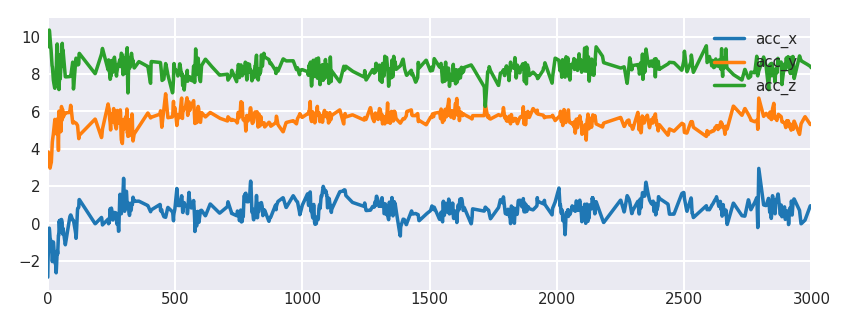

After Scaling:


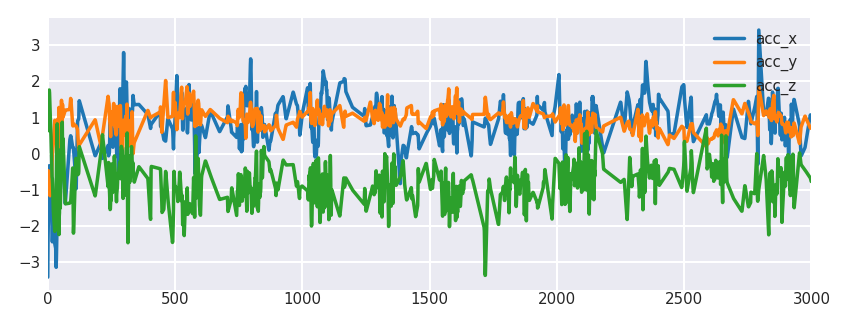

Validation Data:
Before Scaling:


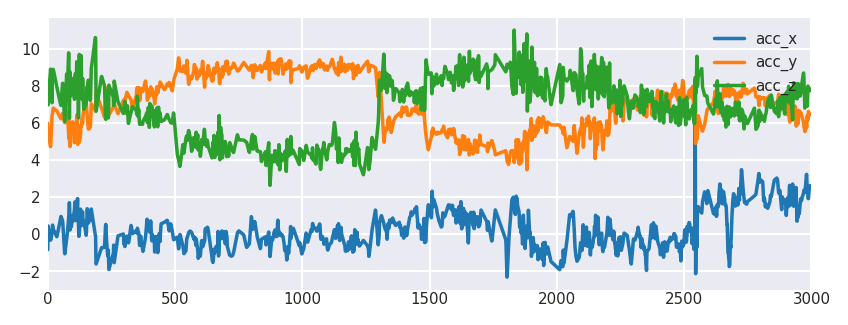

After Scaling:


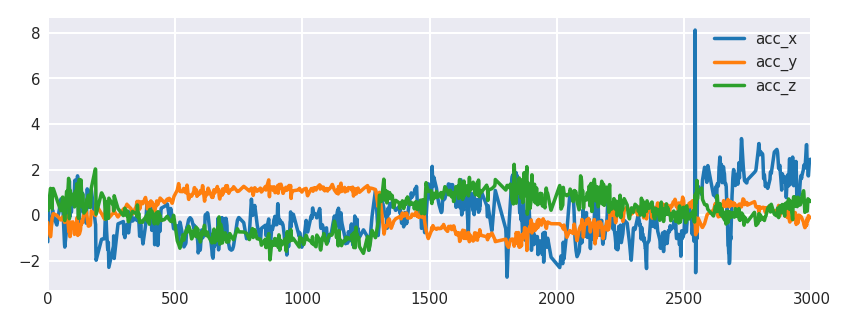

In [11]:
if not P.scaler_global:
    print("Scaling Data for Siamese Network only...")
    print("Training Data:")
    hmog.valid_train, _ = utils_custom_scale(
        hmog.valid_train,
        scale_cols=P.feature_cols,
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,        
    )
    print("Validation Data:")
    hmog.valid_test, _ = utils_custom_scale(
        hmog.valid_test,
        scale_cols=P.feature_cols,        
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,        
    )
else:
    print("Skipped, already normalized.")    

### 2.5 Check Splits <a id='2.5'>&nbsp;</a> 

In [12]:
utils_split_report(hmog.valid_train)

Unique subjects: 40
Unique sessions: 480

Head:


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,subject,session,task_type
0,-3.412751,-0.859470,0.802647,-0.601588,0.193339,0.149184,-4.416808,-18.677058,4.042481,865501,865501_session_12,6
1,-2.399551,-0.473180,1.313625,-0.300374,0.114175,0.497483,-4.240847,-17.911847,3.674885,865501,865501_session_12,6
2,-2.019445,-0.475216,1.095866,-0.160162,0.136490,0.434803,-4.053154,-17.692154,3.456116,865501,865501_session_12,6
3,-1.682592,-0.506074,0.834975,0.111769,0.138812,0.265335,-3.856505,-17.486192,3.230707,865501,865501_session_12,6
4,-1.332844,-0.539390,0.632733,0.102549,0.301903,0.182352,-3.562962,-17.466766,2.962154,865501,865501_session_12,6




Sessions' Task Types per subject:


subject,100669,171538,218719,220962,240168,248252,326223,352716,366286,405035,431312,472761,525584,540641,553321,554303,588087,621276,622852,663153,675397,693572,717868,733568,745224,751131,763813,771782,803262,856302,862649,865501,865881,876011,892687,897652,913228,962159,973891,980953
2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
6,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [13]:
utils_split_report(hmog.valid_test)

Unique subjects: 10
Unique sessions: 120

Head:


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,subject,session,task_type
0,-1.168579,-0.328185,0.229415,-0.068970,-0.272866,0.453358,3.777375,6.74075,-11.045000,808022,808022_session_14,2
1,0.177322,-0.574819,0.207275,-0.193158,-0.035115,0.200259,3.496544,6.55200,-11.031676,808022,808022_session_14,2
2,0.096880,-0.611919,0.303763,-0.172092,0.001737,0.063053,3.292662,6.55200,-10.996147,808022,808022_session_14,2
3,0.016438,-0.649019,0.400250,-0.149948,0.041291,-0.003073,3.088779,6.55200,-10.960618,808022,808022_session_14,2
4,-0.064005,-0.686119,0.496738,-0.127805,0.080844,-0.069199,2.884897,6.55200,-10.925088,808022,808022_session_14,2




Sessions' Task Types per subject:


subject,277905,396697,489146,578526,594887,776328,777078,799296,808022,923862
2,4,4,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4
6,4,4,4,4,4,4,4,4,4,4


In [14]:
utils_split_report(hmog.test_train)

Unique subjects: 10
Unique sessions: 120

Head:


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,subject,session,task_type
0,0.688068,4.688514,9.120988,-0.078252,0.450208,0.695653,6.23400,-14.868125,-34.456750,785873,785873_session_10,4
1,0.542114,4.478009,9.112148,-0.152533,0.455095,0.571525,6.23400,-14.988458,-34.565417,785873,785873_session_10,4
2,0.396160,4.267503,9.103308,-0.226814,0.459982,0.447397,6.23400,-15.108792,-34.674083,785873,785873_session_10,4
3,0.250206,4.056998,9.094467,-0.301096,0.464868,0.323270,6.36225,-15.248875,-34.742000,785873,785873_session_10,4
4,0.104251,3.846492,9.085627,-0.275299,0.499977,0.278209,6.70425,-15.421875,-34.742000,785873,785873_session_10,4




Sessions' Task Types per subject:


subject,186676,201848,264325,368258,698266,710707,785873,815316,827212,879155
2,4,4,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4
6,4,4,4,4,4,4,4,4,4,4


In [15]:
utils_split_report(hmog.test_test)

Unique subjects: 30
Unique sessions: 360

Head:


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,subject,session,task_type
0,-0.204404,5.035904,8.418314,-0.077475,-0.044569,-0.019363,-27.751167,15.160111,-2.113555,579284,579284_session_1,4
1,-0.354591,5.342461,8.230168,0.021356,0.016582,-0.022128,-28.052944,14.979074,-2.555037,579284,579284_session_1,4
2,-0.351473,5.612957,8.443053,0.120188,0.077733,-0.024893,-28.354722,14.798037,-2.996518,579284,579284_session_1,4
3,-0.104447,5.637447,8.342297,0.219019,0.138883,-0.027658,-28.656500,14.617000,-3.437999,579284,579284_session_1,4
4,0.059905,5.838211,8.536127,0.317851,0.200034,-0.030423,-28.958277,14.435963,-3.879481,579284,579284_session_1,4




Sessions' Task Types per subject:


subject,151985,180679,207696,257279,261313,278135,336172,342329,395129,398248,501973,527796,538363,556357,561993,579284,657486,720193,785899,841866,863985,872895,893198,893255,918136,937904,966655,984799,990622,998757
2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
6,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


### 2.6 Reshape Features  <a id='2.6'>&nbsp;</a> 

**Reshape & cache Set for Training Siamese Network:**

In [16]:
df_siamese_train = utils_reshape_features(
    hmog.valid_train,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

# Clean memory
del hmog.train
%reset_selective -f hmog.train

print("Validation data after reshaping:")
display(df_siamese_train.head())

# Store iterim data
df_siamese_train.to_msgpack(OUTPUT_PATH / "df_siamese_train.msg")

# Clean memory
%reset_selective -f df_siamese_train

Validation data after reshaping:


,X,subject,session,task_type
0,"[[1.126538556309365, -5.676733181236054, 3.232...",100669,100669_session_12,6
1,"[[0.35454249979518676, -1.2795481927044285, 0....",100669,100669_session_12,6
2,"[[0.5150551243002253, -1.6982955451723616, 0.6...",100669,100669_session_12,6
3,"[[-0.9393853286507788, -2.2431333573807604, 1....",100669,100669_session_12,6
4,"[[0.00042849556207466284, -2.142130982688511, ...",100669,100669_session_12,6


**Reshape & cache Set for Validating Siamese Network:** (also used to optimize OCSVM)

In [17]:
df_siamese_valid = utils_reshape_features(
    hmog.valid_test,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

del hmog.valid
%reset_selective -f hmog.valid

print("Testing data after reshaping:")
display(df_siamese_valid.head())

# Store iterim data
df_siamese_valid.to_msgpack(OUTPUT_PATH / "df_siamese_valid.msg")

# Clean memory
%reset_selective -f df_siamese_valid

Testing data after reshaping:


,X,subject,session,task_type
0,"[[0.2755904486556705, 0.9555282896636191, 1.54...",277905,277905_session_11,6
1,"[[-0.2562074210816752, 0.709772021775287, -0.3...",277905,277905_session_11,6
2,"[[0.22530963427241976, -0.5863897734333892, 0....",277905,277905_session_11,6
3,"[[1.0569904280299165, -0.05788757446838152, 0....",277905,277905_session_11,6
4,"[[-0.4410834280235254, 0.1232692931937304, -0....",277905,277905_session_11,6


**Reshape & cache Set for Training/Validation OCSVM:**

In [18]:
df_ocsvm_train_valid = utils_reshape_features(
    hmog.test_train,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

del hmog.test_train
%reset_selective -f hmog.test_train

print("Testing data after reshaping:")
display(df_ocsvm_train_valid.head())

# Store iterim data
df_ocsvm_train_valid.to_msgpack(OUTPUT_PATH / "df_ocsvm_train_valid.msg")

# Clean memory
%reset_selective -f df_ocsvm_train_valid

Testing data after reshaping:


,X,subject,session,task_type
0,"[[-8.607810569636623, 0.9955167241816556, -1.9...",186676,186676_session_1,4
1,"[[-0.3209477333333335, 3.128859958333334, 9.44...",186676,186676_session_1,4
2,"[[-2.057314, 4.621461133928572, 7.006203626785...",186676,186676_session_1,4
3,"[[0.534176783756579, 6.0081232518346415, 8.295...",186676,186676_session_1,4
4,"[[-1.53348510239776, 5.71207867121504, 8.14309...",186676,186676_session_1,4


**Reshape & cache Set for Training/Testing OCSVM:**

In [19]:
df_ocsvm_train_test = utils_reshape_features(
    hmog.test_test,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

del hmog.test_test
%reset_selective -f hmog.test_test

print("Testing data after reshaping:")
display(df_ocsvm_train_test.head())

# Store iterim data
df_ocsvm_train_test.to_msgpack(OUTPUT_PATH / "df_ocsvm_train_test.msg")

# Clean memory
%reset_selective -f df_ocsvm_train_test
%reset_selective -f df_

Testing data after reshaping:


,X,subject,session,task_type
0,"[[-0.3765385456074766, 3.1107421714953274, 7.7...",151985,151985_session_10,6
1,"[[0.09549826478869189, 3.9700954602219136, 7.7...",151985,151985_session_10,6
2,"[[0.20883461625482397, 3.2271731154792, 8.6506...",151985,151985_session_10,6
3,"[[0.0038022012564349096, 3.0280049158538764, 9...",151985,151985_session_10,6
4,"[[-2.4728418720348535, 3.5376784001577266, 7.4...",151985,151985_session_10,6


## 3. Generate Scenario Pairs <a id='3'>&nbsp;</a> 

### 3.1 Load cached Data <a id='3.1'>&nbsp;</a> 

In [20]:
df_siamese_train = pd.read_msgpack(OUTPUT_PATH / "df_siamese_train.msg")
df_siamese_valid = pd.read_msgpack(OUTPUT_PATH / "df_siamese_valid.msg")

### 3.2 Build positive/negative Pairs  <a id='3.2'>&nbsp;</a> 

In [21]:
def build_pairs(df):
    # Limit samples per subject to sample of shortest session
    df = df.groupby("session", group_keys=False).apply(
        lambda x: x.sample(min(len(x), P.max_pairs_per_session), random_state=SEED)
    )
    df_pairs = None

    # Split samples subject wise 50:50
    # ---------------
    df_positives = None
    df_negatives = None

    for subject in df["subject"].unique():
        # Shuffle
        df_subj = df[df["subject"] == subject].sample(frac=1, random_state=SEED)

        # Make rows even
        if len(df_subj) % 2 != 0:
            df_subj = df_subj.iloc[:-1]

        half = len(df_subj) // 2

        df_positives = pd.concat([df_positives, df_subj.iloc[:half]])
        df_negatives = pd.concat([df_negatives, df_subj.iloc[half:]])

    # Positive Pairs
    # ---------------
    df_positive_left = None
    df_positive_right = None

    for subject in df_positives["subject"].unique():
        df_subj = df[df["subject"] == subject]
        # Make rows even
        if len(df_subj) % 2 != 0:
            df_subj = df_subj.iloc[:-1]

        # Split in half
        half = len(df_subj) // 2
        df_positive_left = pd.concat([df_positive_left, df_subj.iloc[:half]])
        df_positive_right = pd.concat([df_positive_right, df_subj.iloc[half:]])

    df_positive_left = df_positive_left.reset_index(drop=True)
    df_positive_right = df_positive_right.reset_index(drop=True)
    df_positive_left.columns = ["left_" + c for c in df_positive_left.columns]
    df_positive_right.columns = ["right_" + c for c in df_positive_right.columns]

    df_positives = pd.concat(
        [df_positive_left, df_positive_right],
        axis=1,
        sort=False,
        join_axes=[df_positive_left.index],
    )

    # Negative Pairs
    # ---------------
    # Make rows even
    if len(df_negatives) % 2 != 0:
        df_negatives = df_negatives.iloc[:-1]

    # Split in half
    half = len(df_negatives) // 2
    df_negative_left = df_negatives.iloc[half:].reset_index(drop=True)
    df_negative_right = df_negatives.iloc[:half].reset_index(drop=True)

    # Name columns
    df_negative_left.columns = ["left_" + c for c in df_negative_left.columns]
    df_negative_right.columns = ["right_" + c for c in df_negative_right.columns]

    # Combine
    df_negatives = pd.concat(
        [df_negative_left, df_negative_right],
        axis=1,
        sort=False,
        join_axes=[df_negative_left.index],
    )

    # Combine both Pairs
    # ---------------
    # Balance pairs
    min_len = min(len(df_positives), len(df_negatives))
    df_positives = df_positives.sample(n=min_len, random_state=SEED)
    df_negatives = df_negatives.sample(n=min_len, random_state=SEED)

    # Combine
    df_pairs = pd.concat([df_positives, df_negatives], sort=False)

    # Shuffle
    df_pairs = df_pairs.sample(frac=1, random_state=SEED).reset_index(drop=True)

    # Set Label
    df_pairs["label"] = np.where(
        df_pairs["left_subject"] == df_pairs["right_subject"], 1, 0
    )

    return df_pairs

In [22]:
# Reduce observations/samples per
print("Sample per session before reduction:\n ")
display(df_siamese_train["session"].value_counts().head(3))
display(df_siamese_valid["session"].value_counts().head(3))

df_siamese_train = df_siamese_train.groupby("session", group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), P.samples_per_subject_train), random_state=SEED)
)

df_siamese_valid = df_siamese_valid.groupby("session", group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), P.samples_per_subject_test), random_state=SEED)
)

print("\n\nSample per session after reduction:\n")
display(df_siamese_train["session"].value_counts().head(3))
display(df_siamese_valid["session"].value_counts().head(3))

Sample per session before reduction:
 


771782_session_5    449
733568_session_2    417
876011_session_4    339
Name: session, dtype: int64

396697_session_1    330
489146_session_4    232
489146_session_5    196
Name: session, dtype: int64



Sample per session after reduction:



326223_session_17    120
220962_session_2     120
865881_session_10    120
Name: session, dtype: int64

594887_session_4    120
396697_session_8    120
594887_session_3    120
Name: session, dtype: int64

In [23]:
df_siamese_train_pairs = build_pairs(df_siamese_train)
df_siamese_valid_pairs = build_pairs(df_siamese_valid)

### 3.3 Inspect Pairs <a id='3.3'>&nbsp;</a> 

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23202 entries, 0 to 23201
Data columns (total 9 columns):
left_X             23202 non-null object
left_subject       23202 non-null object
left_session       23202 non-null object
left_task_type     23202 non-null int64
right_X            23202 non-null object
right_subject      23202 non-null object
right_session      23202 non-null object
right_task_type    23202 non-null int64
label              23202 non-null int64
dtypes: int64(3), object(6)
memory usage: 1.6+ MB


None



Head:


,left_X,left_subject,left_session,left_task_type,right_X,right_subject,right_session,right_task_type,label
0,"((-0.6297935210090034, 0.4951728934596526, -0....",763813,763813_session_3,4,"((0.28326749900289105, 2.0060215193377346, -2....",248252,248252_session_15,4,0
1,"((0.5104422682179994, 0.6122515500276577, -0.5...",862649,862649_session_11,6,"((1.2646933163106933, 0.33840824373077677, 0.2...",862649,862649_session_20,2,1
2,"((-1.0483160558913844, 0.29523283522839033, -0...",248252,248252_session_1,6,"((-0.5668663595716247, -0.448976591970793, 0.0...",248252,248252_session_21,2,1
3,"((-0.3345441865487368, -0.7110693097661309, 0....",751131,751131_session_2,6,"((1.0921928655009012, 0.25441181749408487, -0....",240168,240168_session_13,4,0
4,"((0.7168224084245651, 0.9495752606997864, -0.8...",865501,865501_session_12,6,"((-0.37900006110641143, -0.30702400001101776, ...",865501,865501_session_22,4,1




Any NaN values?


left_X             0
left_subject       0
left_session       0
left_task_type     0
right_X            0
right_subject      0
right_session      0
right_task_type    0
label              0
dtype: int64




Distribution of Samples per Subjects in training Data


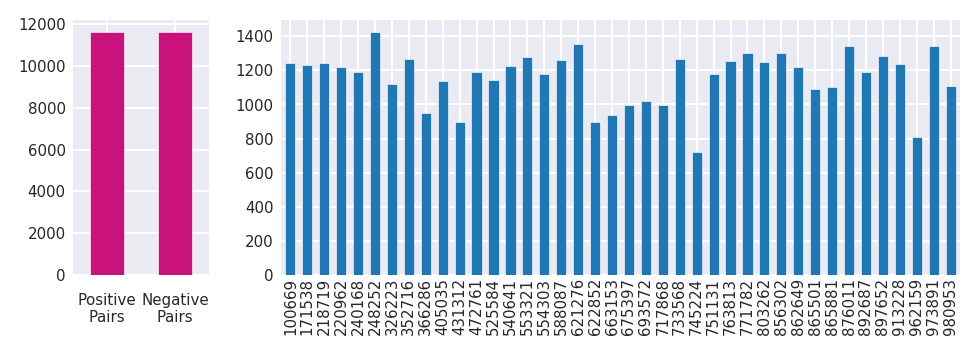

In [24]:
print("DataFrame Info:")
display(df_siamese_train_pairs.info())

print("\n\nHead:")
display(df_siamese_train_pairs.head(5))

print("\n\nAny NaN values?")
display(df_siamese_train_pairs.isnull().sum(axis = 0))

df_left_sub = df_siamese_train_pairs.groupby("left_subject")["left_subject"].count()
df_right_sub = df_siamese_train_pairs.groupby("right_subject")["right_subject"].count()
df_temp = pd.concat([df_left_sub, df_right_sub])

print("\n\n\nDistribution of Samples per Subjects in training Data")

fig, axes = plt.subplots(
    ncols=2, nrows=1, figsize=(5.473, 2), dpi=180, gridspec_kw={"width_ratios": [1, 5]}
)
df_siamese_train_pairs["label"].value_counts().rename(
    index={0: "Negative\nPairs", 1: "Positive\nPairs"}
).plot.bar(ax=axes[0], rot=0, color=MAGENTA)
axes[0].tick_params(axis="x", which="major", pad=7)
df_temp.groupby(df_temp.index).sum().plot.bar(ax=axes[1], width=0.6)
fig.tight_layout()

utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-pair-dist.pdf")

### 3.4 Cache Pairs <a id='3.4'>&nbsp;</a> 

In [25]:
df_siamese_train_pairs.to_msgpack(OUTPUT_PATH / "df_siamese_train_pairs.msg")
df_siamese_valid_pairs.to_msgpack(OUTPUT_PATH / "df_siamese_valid_pairs.msg")

In [26]:
# Clean Memory
%reset_selective -f df_

## 4. Siamese Network <a id='4'>&nbsp;</a> 

### 4.1 Load cached Pairs <a id='4.1'>&nbsp;</a> 

In [27]:
df_siamese_train_pairs = pd.read_msgpack(OUTPUT_PATH / "df_siamese_train_pairs.msg")
df_siamese_valid_pairs = pd.read_msgpack(OUTPUT_PATH / "df_siamese_valid_pairs.msg")

### 4.2 Build Model <a id='4.2'>&nbsp;</a> 

#### Distance Function

In [28]:
def k_euclidean_dist(t):
    x = t[0]
    y = t[1]    
    return K.sqrt(K.sum(K.square(x - y), axis=-1, keepdims=True))

#### Loss Function

In [29]:
def k_contrastive_loss(y_true, dist):
    """Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    margin = P.margin
    return K.mean(y_true * K.square(dist) + (1 - y_true) * K.square(K.maximum(margin - dist, 0)))

Sanity check contrastive loss function:

In [30]:
def contrastive_loss_test(y_true, dist):
    """Test function above using implementation with numpy instead tensors."""
    margin = P.margin
    return y_true * np.square(dist) + (1 - y_true) * np.square(np.max(margin - dist, 0))

In [31]:
print("Positive: class=1, distance=0,     loss:", contrastive_loss_test(1, 0))
print("Positive: class=1, distance=0.01,  loss:", contrastive_loss_test(1, 0.01))
print("Positive: class=1, distance=0.3,   loss:", contrastive_loss_test(1, 0.3))
print("Positive: class=1, distance=0.5,   loss:", contrastive_loss_test(1, 0.5))
print("Positive: class=1, distance=1,     loss:", contrastive_loss_test(1, 1))

Positive: class=1, distance=0,     loss: 0
Positive: class=1, distance=0.01,  loss: 0.0001
Positive: class=1, distance=0.3,   loss: 0.09
Positive: class=1, distance=0.5,   loss: 0.25
Positive: class=1, distance=1,     loss: 1


In [32]:
print("Negative: class=0, distance=0,     loss:", contrastive_loss_test(0, 0))
print("Negative: class=0, distance=0.01,  loss:", contrastive_loss_test(0, 0.01))
print("Negative: class=0, distance=0.3,   loss:", contrastive_loss_test(0, 0.3))
print("Negative: class=0, distance=0.5,   loss:", contrastive_loss_test(0, 0.5))
print("Negative: class=0, distance=5,     loss:", contrastive_loss_test(0, 1))

Negative: class=0, distance=0,     loss: 1
Negative: class=0, distance=0.01,  loss: 0.9801
Negative: class=0, distance=0.3,   loss: 0.48999999999999994
Negative: class=0, distance=0.5,   loss: 0.25
Negative: class=0, distance=5,     loss: 0


#### Siamese Model with 2D Filters, as derived from Centeno et al. (2018)

In [33]:
def build_model_2d(input_shape, filters):
    """
        Siamese CNN architecture with 3D input and 2D filters
    """
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv2D(filters[0], (7, 7), padding="same", activation="tanh", name="conv1")(inputs)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp1")(x)
    x = Conv2D(filters[1], (5, 5), padding="same", activation="tanh", name="conv2")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp2")(x)
    x = Conv2D(filters[2], (3, 3), padding="same", activation="tanh", name="conv3")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp3")(x)
    x = Conv2D(filters[3], (3, 3), padding="same", activation="tanh", name="conv4")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp4")(x)
    x = Flatten(name="flat")(x)
    
    # Basemodel instance
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the distance between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    # Combine into one net
    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

#### Siamese Model with 1D Filters, similar than Centeno et al. (2018)

In [34]:
def build_model_1d(input_shape, filters):
    """
        Model architecture
    """
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv1D(filters[0], 7, activation="elu", padding="same", name="conv1")(inputs)
    x = MaxPooling1D(pool_size=2, name="mp1")(x)
    x = Conv1D(filters[1], 5, activation="elu", padding="same", name="conv2")(x)
    x = MaxPooling1D(pool_size=2, name="mp2")(x)
    x = Conv1D(filters[2], 3, activation="elu", padding="same", name="conv3")(x)
    x = MaxPooling1D(pool_size=2, name="mp3")(x)
    x = Conv1D(filters[3], 3, activation="elu", padding="same", name="conv4")(x)
    x = MaxPooling1D(pool_size=2, name="mp5")(x)
    x = Flatten(name="flat")(x)

    # Generate the encodings (feature vectors) for the two images
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the absolute difference between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

#### Siamese Model with FCN architecture

In [35]:
def build_model_fcn(input_shape, filters):
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv1D(
        filters=filters[0],
        kernel_size=8,
        strides=1,
        activation=None,
        padding="same",
        name="conv1",
    )(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1, name="drop1")(x)
    x = Conv1D(
        filters=filters[1],
        kernel_size=5,
        strides=1,
        activation=None,
        padding="same",
        name="conv2",
    )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1, name="drop2")(x)
    x = Conv1D(
        filters=filters[2],
        kernel_size=3,
        strides=1,
        activation=None,
        padding="same",
        name="conv3",
    )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation="sigmoid", name="dense")(x) # <--- !!!!!!!!!!!!

    # Basemodel instance
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the distance between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    # Combine into one net
    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

In [36]:
def get_model(name, window_size, feature_cols, filters):
    print(f"Using Model variant {name}...")
    if name == "1d":
        model, basemodel = build_model_1d((window_size, len(feature_cols)), filters)
    elif name == "2d":
        model, basemodel = build_model_2d((window_size, len(feature_cols), 1), filters)
    elif name == "fcn":
        model, basemodel = build_model_fcn((window_size, len(feature_cols)), filters)
    else:
        raise BaseException("Error: Not a valid model name: {1d, 2d, fcn}")

    return model, basemodel

**Inspect model architecture:**

In [37]:
temp_model, temp_basemodel = get_model(P.model_variant, P.window_size, P.feature_cols, P.filters)

temp_basemodel.summary()
temp_model.summary()

Using Model variant fcn...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 125, 3)            0         
_________________________________________________________________
conv1 (Conv1D)               (None, 125, 32)           800       
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 32)           128       
_________________________________________________________________
activation_1 (Activation)    (None, 125, 32)           0         
_________________________________________________________________
drop1 (Dropout)              (None, 125, 32)           0         
_________________________________________________________________
conv2 (Conv1D)               (None, 125, 64)           10304     
_________________________________________________________________
batch_normalization_2 (Batch (None, 125, 64)     

### 4.3 Prepare Features <a id='4.3'>&nbsp;</a> 

In [38]:
def prep_X_y_pair(df):
    
    X_left = np.stack(list(df["left_X"].values))
    X_right = np.stack(list(df["right_X"].values))
    
    X = [X_left, X_right]
    y = df["label"].values
    
    return X, y

In [39]:
X_train, y_train = prep_X_y_pair(df_siamese_train_pairs)
X_valid, y_valid = prep_X_y_pair(df_siamese_valid_pairs)

# 2D Filter Model needs flat 4th dimension
if P.model_variant == "2d":
    X_train[0] = X_train[0].reshape((*X_train[0].shape, 1))
    X_train[1] = X_train[1].reshape((*X_train[1].shape, 1))
    X_valid[0] = X_valid[0].reshape((*X_valid[0].shape, 1))
    X_valid[1] = X_valid[1].reshape((*X_valid[1].shape, 1))

print(
    f"Training samples:   {y_train.shape[0]}, shape: {X_train[0].shape},"
    + f" class balance: {np.unique(y_train, return_counts=True)}"
)
print(
    f"Validation samples: {y_valid.shape[0]}, shape: {X_valid[0].shape},"
    + f" class balance: {np.unique(y_valid, return_counts=True)}"
)

Training samples:   23202, shape: (23202, 125, 3), class balance: (array([0, 1]), array([11601, 11601]))
Validation samples: 5584, shape: (5584, 125, 3), class balance: (array([0, 1]), array([2792, 2792]))


### 4.4 Search optimal Epoch <a id='4.4'>&nbsp;</a> 

In [40]:
class MetricsCallback(Callback):
    """
    Custom Keras Callback function.
    
    Used to predict and plot distances for positive and negative pairs
    after each n-th epoch, along with some 'classification' metrics. 
    'Classification' here means to ability to distinguish between positive 
    and negative pairs using a threshold for the distance.
    
    Arguments:
        payload {tuple}           -- Datasets used for evaluation: (X_valid, y_valid, X_train, y_train)
        epoch_evaluate_freq {int} -- Frequency for evaluation. After every n-th epoch, 
                                     the results are evaluated and printed
        save_plots {boolean}      -- Do you want to save plots as PDF? Path is configured via global
                                     parameter REPORT_PATH.
    """

    def __init__(self, payload, epoch_evaluate_freq=1, save_plots=False):

        self.X_valid, self.y_valid, self.X_train, self.y_train = payload
        self.save_plots = save_plots
        self.epoch_evaluate_freq = epoch_evaluate_freq

        # Do we have train and valid set?
        self.sets = []
        if self.X_train:
            self.sets.append([self.X_train, self.y_train, "Train"])
        if self.X_valid:
            self.sets.append([self.X_valid, self.y_valid, "Valid"])

    def on_train_begin(self, logs={}):
        print(32 * "=" + f"[ Initial State ]" + 32 * "=", end="")
        for X, y, desc in self.sets:
            self.evaluate(X, y, logs, desc, -1)

    def on_train_end(self, logs={}):
        print(32 * "=" + f"[ Final State ]" + 32 * "=", end="")
        for X, y, desc in self.sets:
            self.evaluate(X, y, logs, desc, -1)

    def on_epoch_end(self, epoch, logs={}):
        print(32 * "=" + f"[   Epoch {epoch}   ]" + 32 * "=", end="")
        if epoch % self.epoch_evaluate_freq == 0:  # Evaluate only every n-th epoch
            for X, y, desc in self.sets:
                self.evaluate(X, y, logs, desc, epoch)
        else:
            print(f"\n{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }")

    def evaluate(self, X, y, logs, desc, epoch):
        # Predict
        y_score = self.model.predict(X)
        y_score_neg = y_score * -1  # lower distance means closer to positive class

        # Calc Metrics
        roc_val = metrics.roc_auc_score(y, y_score_neg)
        eer_val, thres = utils_eer(y, y_score_neg, True)
        y_pred = np.where(y_score_neg > thres, 1, 0)
        acc_val = metrics.accuracy_score(y, y_pred)
        f1_val = metrics.f1_score(y, y_pred)

        print(
            f"\n{desc.upper()}: roc_auc: {roc_val:.4f}, "
            + f"eer: {eer_val:.4f}, thres: {thres*-1:.4f} => "
            + f"acc: {acc_val:.4f}, f1: {f1_val:.4f}\n"
            + f"{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }"
        )

        # Plot distances
        mask = np.where(y == 1, True, False)
        dist_positive = y_score[mask]
        dist_negative = y_score[~mask]
        plt = utils_plot_distance_hist(
            dist_positive, dist_negative, thres * -1, desc=desc, margin=P.margin
        )

        if self.save_plots:
            utils_save_plot(
                plt,
                REPORT_PATH
                / f"buech2019-siamese-{P.name.lower()}-epoch-{epoch+1}-{desc.lower()}.pdf",
            )

        plt.show()

In [41]:
def get_optimizer(name, lr=None, decay=None):
    if name == "sgd":
        lr = lr if lr != None else 0.01
        decay = decay if decay != None else 0
        optimizer = SGD(lr=lr, decay=decay)
    elif name == "adam":
        lr = lr if lr != None else 0.001
        decay = decay if decay != None else 0
        optimizer = Adam(lr=lr, decay=decay)
    elif name == "rmsprop":
        lr = lr if lr != None else 0.001
        optimizer = RMSprop(lr=lr)
    else:
        raise BaseException("Error: Not a valid model name: 1d or 2d.")
    return optimizer

Using Model variant fcn...
================================[ Initial State ]================================
TRAIN: roc_auc: 0.5017, eer: 0.5006, thres: 0.0647 => acc: 0.4994, f1: 0.4994



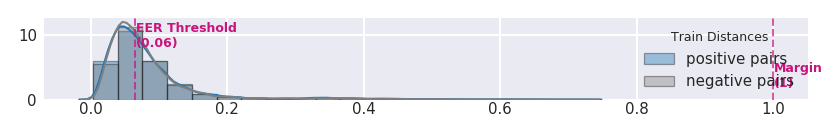


VALID: roc_auc: 0.4890, eer: 0.5197, thres: 0.0638 => acc: 0.4803, f1: 0.4803



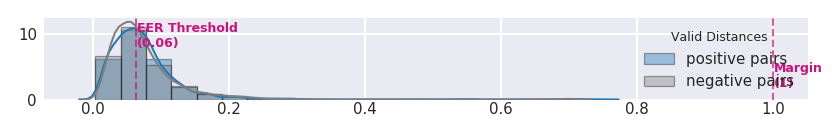

================================[   Epoch 0   ]================================
TRAIN: roc_auc: 0.5871, eer: 0.4438, thres: 0.4581 => acc: 0.5561, f1: 0.5561
val_loss: 0.256, loss: 0.265


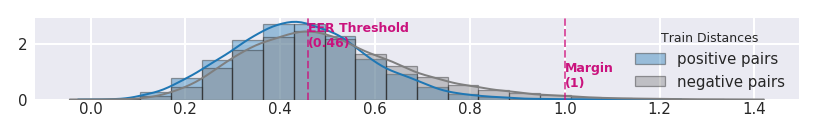


VALID: roc_auc: 0.5652, eer: 0.4556, thres: 0.4568 => acc: 0.5442, f1: 0.5442
val_loss: 0.256, loss: 0.265


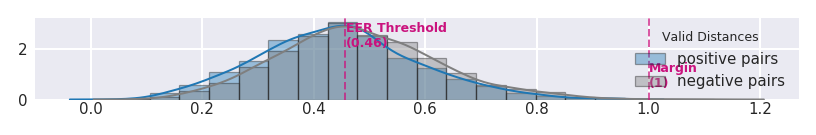

================================[   Epoch 1   ]================================
val_loss: 0.226, loss: 0.243
================================[   Epoch 2   ]================================
val_loss: 0.229, loss: 0.234
================================[   Epoch 3   ]================================
val_loss: 0.212, loss: 0.228
================================[   Epoch 4   ]================================
val_loss: 0.198, loss: 0.223
================================[   Epoch 5   ]================================
TRAIN: roc_auc: 0.7085, eer: 0.3557, thres: 0.4884 => acc: 0.6443, f1: 0.6443
val_loss: 0.194, loss: 0.218


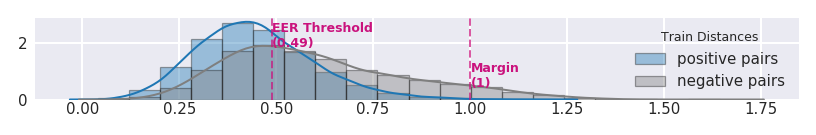


VALID: roc_auc: 0.7745, eer: 0.2976, thres: 0.5165 => acc: 0.7025, f1: 0.7025
val_loss: 0.194, loss: 0.218


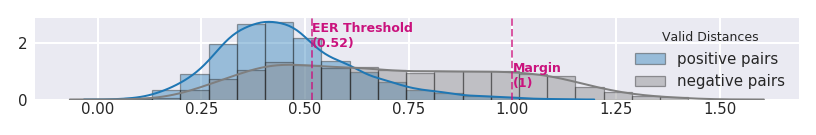

================================[   Epoch 6   ]================================
val_loss: 0.193, loss: 0.216
================================[   Epoch 7   ]================================
val_loss: 0.195, loss: 0.213
================================[   Epoch 8   ]================================
val_loss: 0.186, loss: 0.211
================================[   Epoch 9   ]================================
val_loss: 0.183, loss: 0.208
================================[   Epoch 10   ]================================
TRAIN: roc_auc: 0.7337, eer: 0.3342, thres: 0.4891 => acc: 0.6658, f1: 0.6657
val_loss: 0.190, loss: 0.206


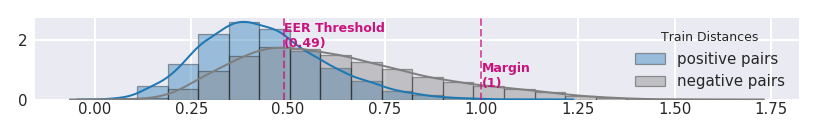


VALID: roc_auc: 0.7857, eer: 0.2966, thres: 0.5314 => acc: 0.7033, f1: 0.7032
val_loss: 0.190, loss: 0.206


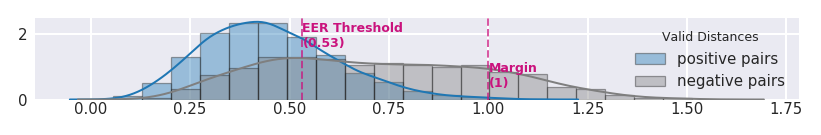

================================[   Epoch 11   ]================================
val_loss: 0.186, loss: 0.206
================================[   Epoch 12   ]================================
val_loss: 0.182, loss: 0.203
================================[   Epoch 13   ]================================
val_loss: 0.182, loss: 0.203
================================[   Epoch 14   ]================================
val_loss: 0.182, loss: 0.202
================================[   Epoch 15   ]================================
TRAIN: roc_auc: 0.7597, eer: 0.3160, thres: 0.4808 => acc: 0.6839, f1: 0.6839
val_loss: 0.187, loss: 0.201


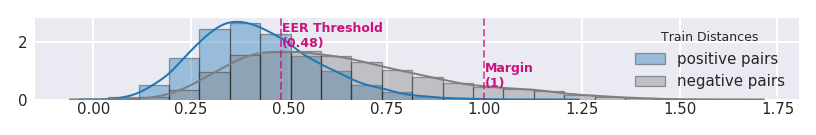


VALID: roc_auc: 0.7909, eer: 0.2872, thres: 0.5219 => acc: 0.7126, f1: 0.7124
val_loss: 0.187, loss: 0.201


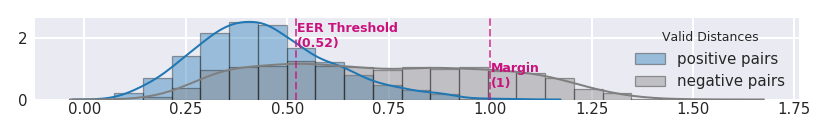

================================[   Epoch 16   ]================================
val_loss: 0.182, loss: 0.199
================================[   Epoch 17   ]================================
val_loss: 0.184, loss: 0.199
================================[   Epoch 18   ]================================
val_loss: 0.190, loss: 0.197
================================[   Epoch 19   ]================================
val_loss: 0.186, loss: 0.196
================================[   Epoch 20   ]================================
TRAIN: roc_auc: 0.7734, eer: 0.3024, thres: 0.4852 => acc: 0.6977, f1: 0.6977
val_loss: 0.180, loss: 0.196


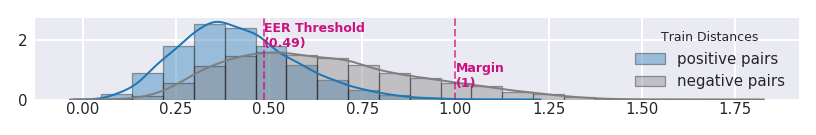


VALID: roc_auc: 0.8068, eer: 0.2761, thres: 0.5151 => acc: 0.7240, f1: 0.7240
val_loss: 0.180, loss: 0.196


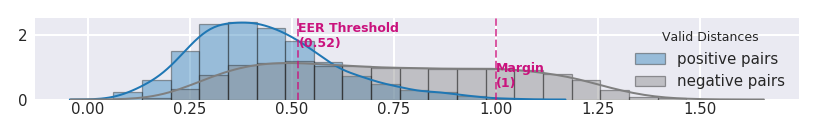

================================[   Epoch 21   ]================================
val_loss: 0.180, loss: 0.196
================================[   Epoch 22   ]================================
val_loss: 0.179, loss: 0.194
================================[   Epoch 23   ]================================
val_loss: 0.185, loss: 0.194
================================[   Epoch 24   ]================================
val_loss: 0.179, loss: 0.192
================================[   Epoch 25   ]================================
TRAIN: roc_auc: 0.7837, eer: 0.2973, thres: 0.4970 => acc: 0.7027, f1: 0.7027
val_loss: 0.182, loss: 0.191


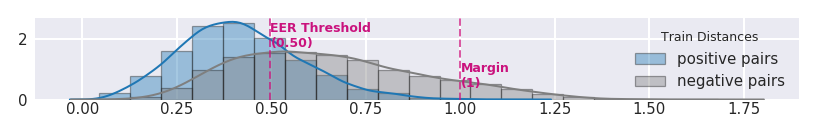


VALID: roc_auc: 0.8063, eer: 0.2787, thres: 0.5356 => acc: 0.7215, f1: 0.7215
val_loss: 0.182, loss: 0.191


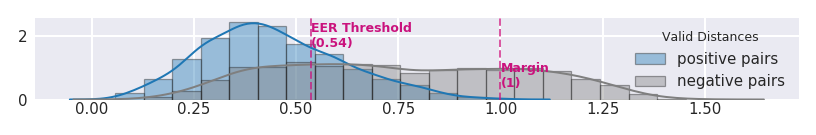

================================[   Epoch 26   ]================================
val_loss: 0.178, loss: 0.191
================================[   Epoch 27   ]================================
val_loss: 0.183, loss: 0.190
================================[   Epoch 28   ]================================
val_loss: 0.179, loss: 0.189
================================[   Epoch 29   ]================================
val_loss: 0.180, loss: 0.189
================================[   Epoch 30   ]================================
TRAIN: roc_auc: 0.7985, eer: 0.2832, thres: 0.4991 => acc: 0.7168, f1: 0.7168
val_loss: 0.180, loss: 0.187


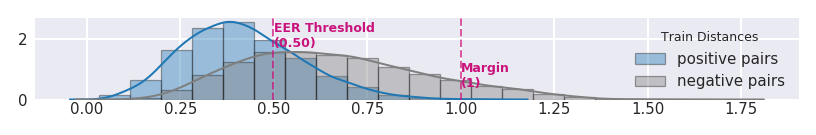


VALID: roc_auc: 0.8127, eer: 0.2797, thres: 0.5327 => acc: 0.7205, f1: 0.7204
val_loss: 0.180, loss: 0.187


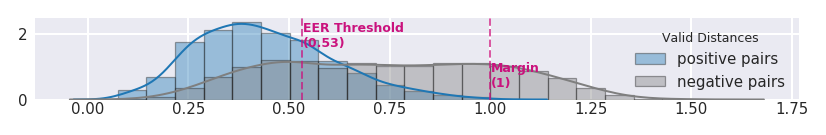

================================[   Epoch 31   ]================================
val_loss: 0.178, loss: 0.188
================================[   Epoch 32   ]================================
val_loss: 0.181, loss: 0.187
================================[   Epoch 33   ]================================
val_loss: 0.182, loss: 0.186
================================[   Epoch 34   ]================================
val_loss: 0.184, loss: 0.185
================================[   Epoch 35   ]================================
TRAIN: roc_auc: 0.8018, eer: 0.2776, thres: 0.4917 => acc: 0.7224, f1: 0.7223
val_loss: 0.178, loss: 0.185


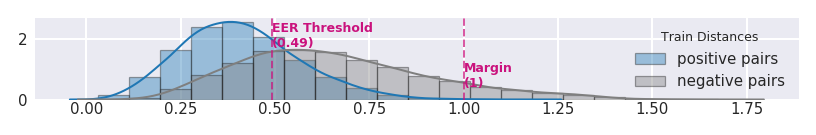


VALID: roc_auc: 0.8105, eer: 0.2790, thres: 0.5190 => acc: 0.7212, f1: 0.7211
val_loss: 0.178, loss: 0.185


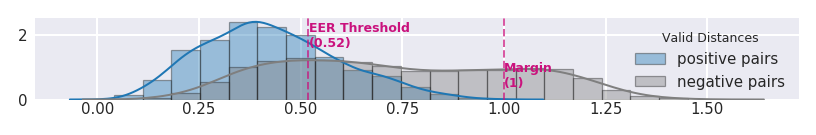

================================[   Epoch 36   ]================================
val_loss: 0.176, loss: 0.185
================================[   Epoch 37   ]================================
val_loss: 0.176, loss: 0.183
================================[   Epoch 38   ]================================
val_loss: 0.178, loss: 0.183
================================[   Epoch 39   ]================================
val_loss: 0.180, loss: 0.182
================================[   Epoch 40   ]================================
TRAIN: roc_auc: 0.8123, eer: 0.2698, thres: 0.4936 => acc: 0.7302, f1: 0.7301
val_loss: 0.179, loss: 0.183


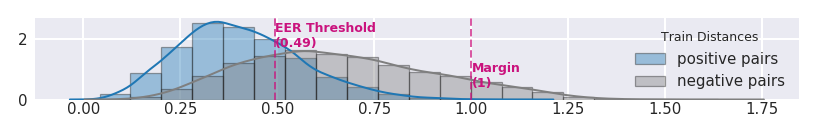


VALID: roc_auc: 0.8116, eer: 0.2741, thres: 0.5225 => acc: 0.7260, f1: 0.7259
val_loss: 0.179, loss: 0.183


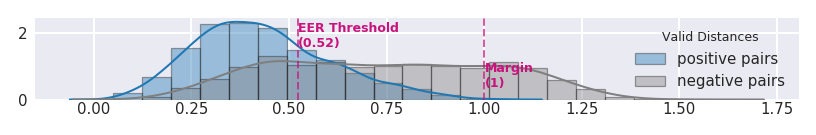

================================[   Epoch 41   ]================================
val_loss: 0.179, loss: 0.182
================================[   Epoch 42   ]================================
val_loss: 0.177, loss: 0.182
================================[   Epoch 43   ]================================
val_loss: 0.188, loss: 0.180
================================[   Epoch 44   ]================================
val_loss: 0.180, loss: 0.180
================================[   Epoch 45   ]================================
TRAIN: roc_auc: 0.8156, eer: 0.2670, thres: 0.4919 => acc: 0.7329, f1: 0.7329
val_loss: 0.178, loss: 0.180


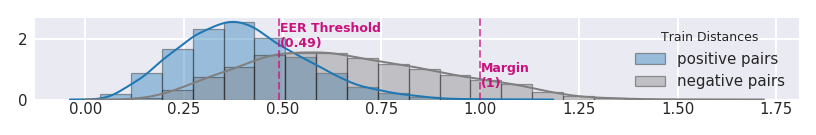


VALID: roc_auc: 0.8105, eer: 0.2783, thres: 0.5193 => acc: 0.7219, f1: 0.7218
val_loss: 0.178, loss: 0.180


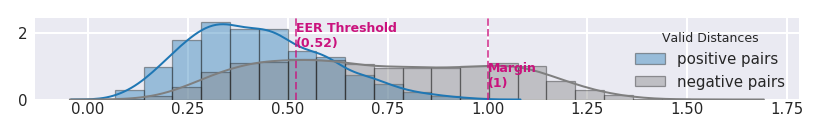

================================[   Epoch 46   ]================================
val_loss: 0.180, loss: 0.179
================================[   Epoch 47   ]================================
val_loss: 0.182, loss: 0.178
================================[   Epoch 48   ]================================
val_loss: 0.181, loss: 0.178
================================[   Epoch 49   ]================================
val_loss: 0.183, loss: 0.178
================================[   Epoch 50   ]================================
TRAIN: roc_auc: 0.8199, eer: 0.2634, thres: 0.4932 => acc: 0.7366, f1: 0.7366
val_loss: 0.182, loss: 0.177


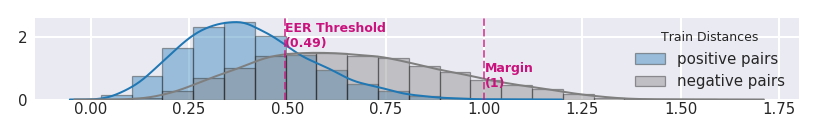


VALID: roc_auc: 0.8021, eer: 0.2847, thres: 0.5258 => acc: 0.7151, f1: 0.7149
val_loss: 0.182, loss: 0.177


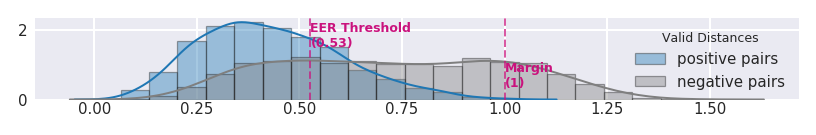

================================[   Epoch 51   ]================================
val_loss: 0.182, loss: 0.177
================================[   Epoch 52   ]================================
val_loss: 0.185, loss: 0.177
================================[   Epoch 53   ]================================
val_loss: 0.181, loss: 0.177
================================[   Epoch 54   ]================================
val_loss: 0.185, loss: 0.176
================================[   Epoch 55   ]================================
TRAIN: roc_auc: 0.8311, eer: 0.2514, thres: 0.4854 => acc: 0.7487, f1: 0.7487
val_loss: 0.179, loss: 0.176


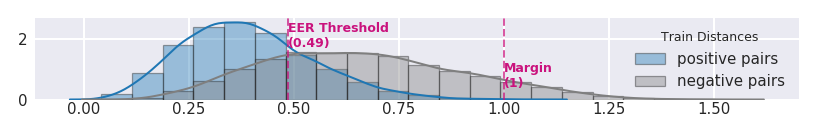


VALID: roc_auc: 0.8055, eer: 0.2830, thres: 0.5094 => acc: 0.7170, f1: 0.7169
val_loss: 0.179, loss: 0.176


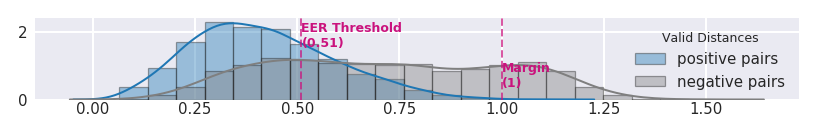

================================[   Epoch 56   ]================================
val_loss: 0.181, loss: 0.176
================================[   Epoch 57   ]================================
val_loss: 0.182, loss: 0.175
================================[   Epoch 58   ]================================
val_loss: 0.182, loss: 0.174
================================[   Epoch 59   ]================================
val_loss: 0.178, loss: 0.173
================================[   Epoch 60   ]================================
TRAIN: roc_auc: 0.8267, eer: 0.2558, thres: 0.5006 => acc: 0.7442, f1: 0.7441
val_loss: 0.183, loss: 0.174


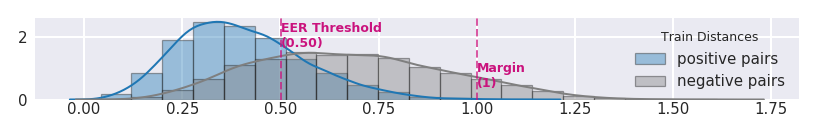


VALID: roc_auc: 0.8025, eer: 0.2815, thres: 0.5329 => acc: 0.7185, f1: 0.7185
val_loss: 0.183, loss: 0.174


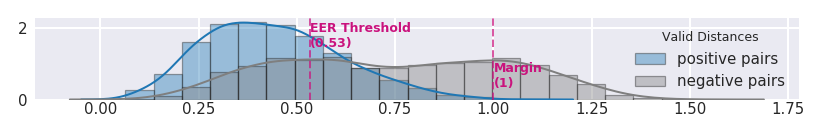

================================[   Epoch 61   ]================================
val_loss: 0.183, loss: 0.174
================================[   Epoch 62   ]================================
val_loss: 0.181, loss: 0.173
================================[   Epoch 63   ]================================
val_loss: 0.179, loss: 0.172
================================[   Epoch 64   ]================================
val_loss: 0.182, loss: 0.173
================================[   Epoch 65   ]================================
TRAIN: roc_auc: 0.8349, eer: 0.2506, thres: 0.4971 => acc: 0.7494, f1: 0.7494
val_loss: 0.180, loss: 0.172


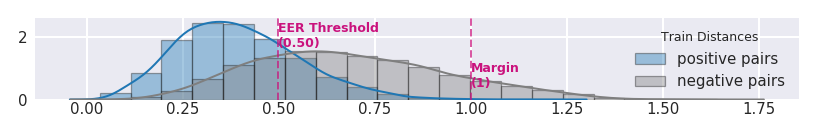


VALID: roc_auc: 0.8051, eer: 0.2785, thres: 0.5231 => acc: 0.7213, f1: 0.7213
val_loss: 0.180, loss: 0.172


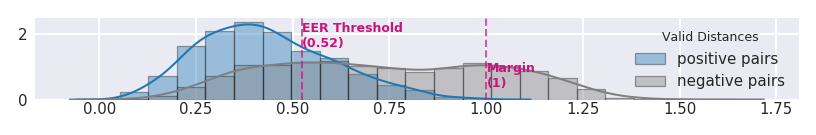

================================[   Epoch 66   ]================================
val_loss: 0.181, loss: 0.172
================================[   Epoch 67   ]================================
val_loss: 0.180, loss: 0.171
================================[   Epoch 68   ]================================
val_loss: 0.183, loss: 0.170
================================[   Epoch 69   ]================================
val_loss: 0.185, loss: 0.172
================================[   Epoch 70   ]================================
TRAIN: roc_auc: 0.8413, eer: 0.2430, thres: 0.4916 => acc: 0.7570, f1: 0.7570
val_loss: 0.180, loss: 0.170


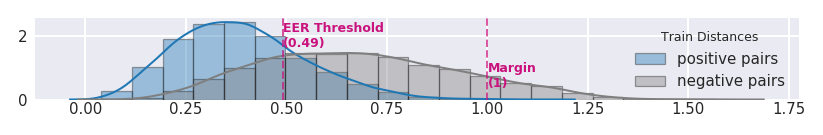


VALID: roc_auc: 0.8073, eer: 0.2772, thres: 0.5187 => acc: 0.7228, f1: 0.7228
val_loss: 0.180, loss: 0.170


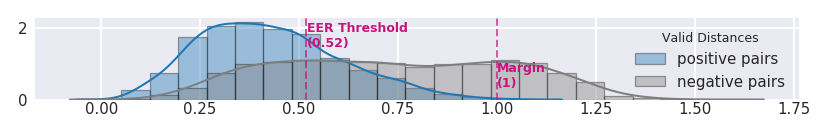

================================[   Epoch 71   ]================================
val_loss: 0.180, loss: 0.170
================================[   Epoch 72   ]================================
val_loss: 0.183, loss: 0.170
================================[   Epoch 73   ]================================
val_loss: 0.181, loss: 0.169
================================[   Epoch 74   ]================================
val_loss: 0.181, loss: 0.169
================================[   Epoch 75   ]================================
TRAIN: roc_auc: 0.8371, eer: 0.2483, thres: 0.4955 => acc: 0.7516, f1: 0.7516
val_loss: 0.180, loss: 0.169


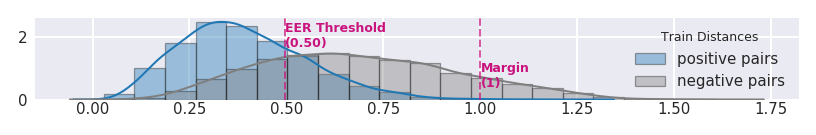


VALID: roc_auc: 0.8064, eer: 0.2765, thres: 0.5243 => acc: 0.7237, f1: 0.7236
val_loss: 0.180, loss: 0.169


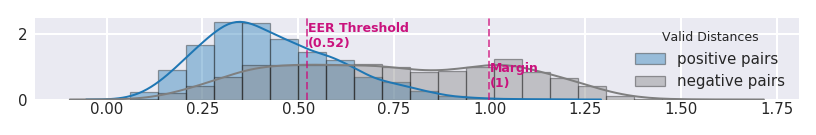

================================[   Epoch 76   ]================================
val_loss: 0.177, loss: 0.169
================================[   Epoch 77   ]================================
val_loss: 0.181, loss: 0.168
================================[   Epoch 78   ]================================
val_loss: 0.177, loss: 0.168
================================[   Epoch 79   ]================================
val_loss: 0.175, loss: 0.167
================================[ Final State ]================================
TRAIN: roc_auc: 0.8410, eer: 0.2438, thres: 0.4915 => acc: 0.7562, f1: 0.7562



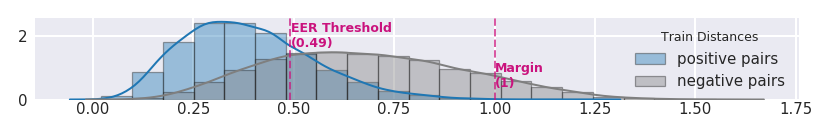


VALID: roc_auc: 0.8164, eer: 0.2715, thres: 0.5109 => acc: 0.7282, f1: 0.7280



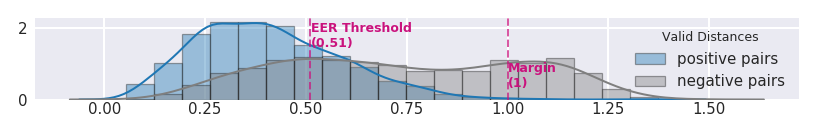

Training History:


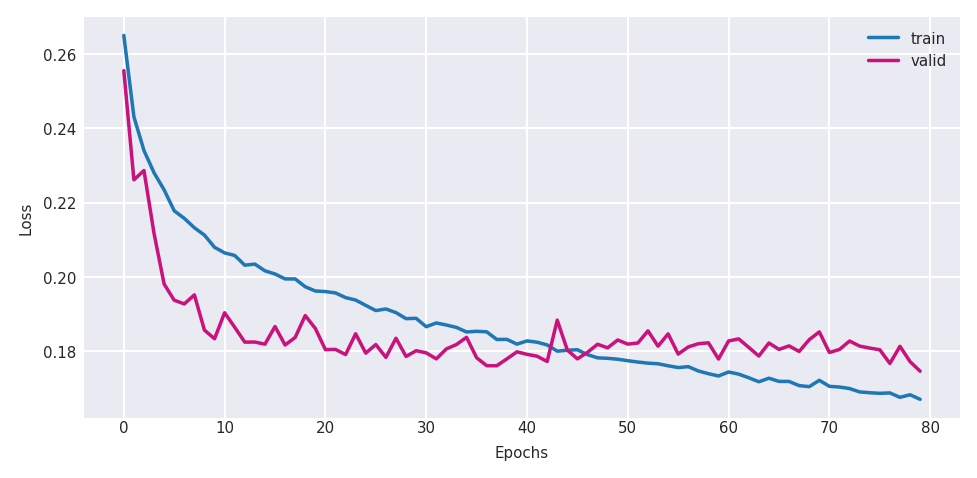

In [42]:
# Select model architecture
model, basemodel = get_model(P.model_variant, P.window_size, P.feature_cols, P.filters)

# Select Optimizer
optimizer = get_optimizer(P.optimizer, P.optimizer_lr)

# Compile
warnings.filterwarnings("ignore")
model.compile(loss=k_contrastive_loss, optimizer=optimizer)

# Train
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=P.batch_size,
    epochs=P.epochs_max,
    verbose=0,
    validation_data=(X_valid, y_valid),
    callbacks=[MetricsCallback((X_valid, y_valid, X_train, y_train), epoch_evaluate_freq=5, save_plots=True)],
)

print("Training History:")
plt = utils_plot_training_loss(history)
utils_save_plot(
    plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-epoch-trainloss.pdf"
)
plt.show()

### 4.5 Check Distances <a id='4.5'>&nbsp;</a> 

Mean distance: 0.57477
Max distance: 1.44117
Min distance: 0.05475


Histogram of Pair Distances:


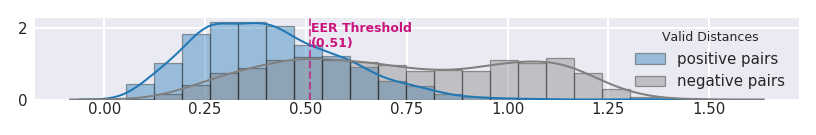

In [43]:
# Predic validation set
dists = model.predict(X_valid)

# Stats
print(f"Mean distance: {dists.mean():.5f}")
print(f"Max distance: {dists.max():.5f}")
print(f"Min distance: {dists.min():.5f}\n")

# Histrogram
print("\nHistogram of Pair Distances:")
eer_val, thres = utils_eer(y_valid, dists, True)
mask = np.where(y_valid == 1, True, False)
dist_positive = dists[mask]
dist_negative = dists[~mask]
plt = utils_plot_distance_hist(dist_positive, dist_negative, thres, "Valid")
plt.show()

### 4.6 Rebuild and train to optimal Epoch  <a id='4.6'>&nbsp;</a> 
Now, that we know the learning curve, we can rebuild the model and train it until the best Epoch.

Also, we will include the validation data to have more training data. 

**Note:** This also means, that the training metrics are not valid anymore, because we don't have any validation data left to test against...

In [5]:
# Concat train & valid data
X_train_valid = [[], []]
X_train_valid[0] = np.vstack([X_train[0], X_valid[0]])
X_train_valid[1] = np.vstack([X_train[1], X_valid[1]])
y_train_valid = np.hstack([y_train, y_valid])

# Select model architecture
model, basemodel = get_model(P.model_variant, P.window_size, P.feature_cols, P.filters)

# Select Optimizer
optimizer = get_optimizer(P.optimizer, P.optimizer_lr)
    
# Compile
model.compile(loss=k_contrastive_loss, optimizer=optimizer)

# Train
history = model.fit(
    x=X_train_valid,
    y=y_train_valid,
    batch_size=P.batch_size,
    epochs=P.epochs_best,
    verbose=0,
    callbacks=[MetricsCallback((None, None, X_train, y_train), epoch_evaluate_freq=10, save_plots=False)],
)

NameError: name 'X_train' is not defined

### 4.7 Cache model <a id='4.7'>&nbsp;</a> 

In [ ]:
model.save(str((OUTPUT_PATH / f"{P.name}_model.h5").resolve()))

In [ ]:
# Clean Memory
%reset_selective -f df_
%reset_selective -f X_
%reset_selective -f y_

## 5. Visualize Deep Features <a id='5'>&nbsp;</a> 

### 5.1 Load cached Data <a id='5.1'>&nbsp;</a> 

In [6]:
print (OUTPUT_PATH/ "df_siamese_valid.msg")
df_siamese_valid = pd.read_msgpack(OUTPUT_PATH / "df_siamese_valid.msg")
df_siamese_train = pd.read_msgpack(OUTPUT_PATH / "df_siamese_train.msg")

df_ocsvm_train_valid = pd.read_msgpack(OUTPUT_PATH / "df_ocsvm_train_valid.msg")

/gpfs/fs1/home/u/uhengart/ezzeldi/Untitled Folder/ContinAuth/notebooks/output/chapter-6-1-4-siamese-cnn/df_siamese_valid.msg


### 5.2 Extract CNN from Siamese Model <a id='5.2'>&nbsp;</a> 
I do this by redirecting inputs and outputs.

However, the network still needs a pair as input (I wasn't able to change this). This slows down a little bit the prediction (as the input is predicted twice), but doesn't change the results.

In [7]:
def load_deep_feature_model(model_path):
    # Copy of function from above. It's just more convenient for partially 
    # executing the notebook.
    def k_contrastive_loss(y_true, dist):
        """Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        """
        margin = P.margin
        return K.mean(
            y_true * K.square(dist)
            + (1 - y_true) * K.square(K.maximum(margin - dist, 0))
        )
    
    # Load Trained Siamese Network
    model = load_model(
        str(model_path.resolve()),
        custom_objects={"k_contrastive_loss": k_contrastive_loss},
    )

    # Extract one of the child networks
    deep_feature_model = Model(
        inputs=model.get_input_at(0),  # get_layer("left_inputs").input,
        outputs=model.get_layer("basemodel").get_output_at(1),
    )
    
    return deep_feature_model

In [13]:
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")
deep_feature_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
left_inputs (InputLayer)     (None, 125, 3)            0         
_________________________________________________________________
basemodel (Model)            (None, 32)                18848     
Total params: 18,848
Trainable params: 18,592
Non-trainable params: 256
_________________________________________________________________


### 5.3 Test Generation of Deep Features <a id='5.3'>&nbsp;</a> 

In [14]:
def prep_X_y_single(df):
    X = np.stack(list(df["X"].values))
    y = df["label"].values
    return X, y

In [15]:
def transform_to_sample_by_subject(df):
    sample_by_subject = []
    df["label"] = 1
    for subj in df["subject"].unique():
        df_subj = df[df["subject"] == subj]
        X_sub, y_sub = prep_X_y_single(df_subj)
        sample_by_subject.append((X_sub, y_sub, subj))
    return sample_by_subject

#### Select subset (for plotting) and transform features

In [16]:
# Concat Valid & Train (both were used for last Training)
df_train_temp = pd.concat([df_siamese_valid, df_siamese_train])
df_test_temp = df_ocsvm_train_valid

# Select data from 20 subjects of the TRAINING SET
random.seed(SEED)
ten_subjects = random.sample(df_train_temp["subject"].unique().tolist(), 20)
df_train_temp = df_train_temp[df_train_temp["subject"].isin(ten_subjects)].copy()
df_train_temp = df_train_temp.groupby("subject").apply(lambda x: x.sample(n=300, random_state=SEED))  # Plot only subset of samples

# Select data from 10 subjects of the TEST SET (not included in training)
random.seed(SEED)
ten_subjects = random.sample(df_test_temp["subject"].unique().tolist(), 10)
df_test_temp = df_test_temp[df_ocsvm_train_valid["subject"].isin(ten_subjects)].copy()
df_test_temp = df_test_temp.groupby("subject").apply(lambda x: x.sample(n=300, random_state=SEED))  # Plot only subset of samples

# Transform Samples
samples_train = transform_to_sample_by_subject(df_train_temp)
samples_test = transform_to_sample_by_subject(df_test_temp)

print(f"First subject: {samples_train[0][2]}")
print(f"y shape: {samples_train[0][1].shape}")
print(f"X shape: {samples_train[0][0].shape}")

First subject: 218719
y shape: (300,)
X shape: (300, 125, 3)


#### Predict Deep Features

In [17]:
deep_features_train = None
for X, y, subj in samples_train:  
    if P.model_variant == "2d":
        X = X.reshape((*X.shape, 1))
    pred = deep_feature_model.predict([X, X])
    df_features = pd.DataFrame(pred)
    df_features["subject"] = subj
    deep_features_train = pd.concat([deep_features_train, df_features])
        
deep_features_test = None
for X, y, subj in samples_test:  
    if P.model_variant == "2d":
        X = X.reshape((*X.shape, 1))
    pred = deep_feature_model.predict([X, X])
    df_features = pd.DataFrame(pred)
    df_features["subject"] = subj
    deep_features_test = pd.concat([deep_features_test, df_features])
        
display(deep_features_train.head(3))
display(deep_features_test.head(3))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,subject
0,0.531752,0.450091,0.575938,0.482379,0.478745,0.455122,0.552329,0.507984,0.481965,0.502132,0.479695,0.541795,0.513756,0.443160,0.541065,0.547507,0.468410,0.488540,0.464900,0.442866,0.543424,0.454774,0.386284,0.559653,0.507732,0.469102,0.546708,0.523307,0.455691,0.482247,0.451578,0.429889,218719
1,0.500776,0.450945,0.552884,0.506826,0.507164,0.489467,0.530966,0.518132,0.530268,0.507042,0.488051,0.510581,0.516203,0.466492,0.488503,0.512638,0.500111,0.479785,0.502544,0.472408,0.534174,0.491502,0.435432,0.529135,0.503180,0.504537,0.517965,0.482734,0.488393,0.493471,0.445135,0.418202,218719
2,0.513837,0.476167,0.590215,0.487476,0.465160,0.468960,0.540390,0.511207,0.489807,0.519800,0.524023,0.518163,0.519284,0.445757,0.570470,0.544899,0.431902,0.457437,0.460512,0.487788,0.528296,0.452307,0.390005,0.592343,0.531414,0.450632,0.566602,0.529779,0.446664,0.449180,0.481943,0.429419,218719


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,subject
0,0.896005,0.024812,0.699620,0.193194,0.995855,0.269598,0.656378,0.800322,0.953667,0.998351,0.037657,0.233647,0.735082,0.834156,0.144633,0.689176,0.829158,0.340513,0.085437,0.428459,0.986116,0.063360,0.001554,0.300029,0.709580,0.319320,0.858897,0.975613,0.705820,1.0,0.132959,0.123840,186676
1,0.886210,0.017154,0.974127,0.267904,0.933731,0.156099,0.770575,0.425218,0.773569,0.999999,0.058602,0.024614,0.588042,0.160096,0.274658,0.912011,0.761242,0.296009,0.030776,0.224625,0.992747,0.229032,0.003125,0.653176,0.552677,0.047809,0.652599,0.992112,0.190876,1.0,0.217580,0.004439,186676
2,0.897601,0.023077,0.641061,0.192557,0.997521,0.280849,0.646640,0.823469,0.958903,0.997998,0.042040,0.295652,0.765185,0.857385,0.111067,0.651020,0.829240,0.328866,0.109966,0.439558,0.984220,0.054118,0.001266,0.236514,0.787096,0.376712,0.887207,0.971782,0.767649,1.0,0.128193,0.127566,186676


### 5.4 Visualize in 2D using PCA <a id='5.4'>&nbsp;</a> 

In [18]:
def plot_pca(df):
    # PCA
    pca = PCA(n_components=2)
    deep_transformed = pca.fit_transform(df.drop(columns=["subject"]).values)

    # Create df with data needed for chart only
    df_viz = df.copy()
    df_viz["PCA0"] = deep_transformed[:, 0]
    df_viz["PCA1"] = deep_transformed[:, 1]
    df_viz.drop(
        columns=[c for c in df_viz.columns if c not in ["PCA0", "PCA1", "subject"]]
    )

    # Generate color index for every subject
    df_viz["Subject"] = pd.Categorical(df_viz["subject"])
    df_viz["colors"] = df_viz["Subject"].cat.codes

    if len(df_viz["Subject"].unique()) <= 10:
        pal = sns.color_palette("tab10")
    else:
        pal = sns.color_palette("tab20")
        
    # Actual plot
    fig = plt.figure(figsize=(5.473 / 1.5, 5.473 / 2), dpi=180)
    sns.scatterplot(
        x="PCA0",
        y="PCA1",
        data=df_viz,
        hue="Subject",
        legend="full",
        palette=pal,
        s=2,
        linewidth=0,
        alpha=0.6,
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=5)
    fig.tight_layout()
    return plt

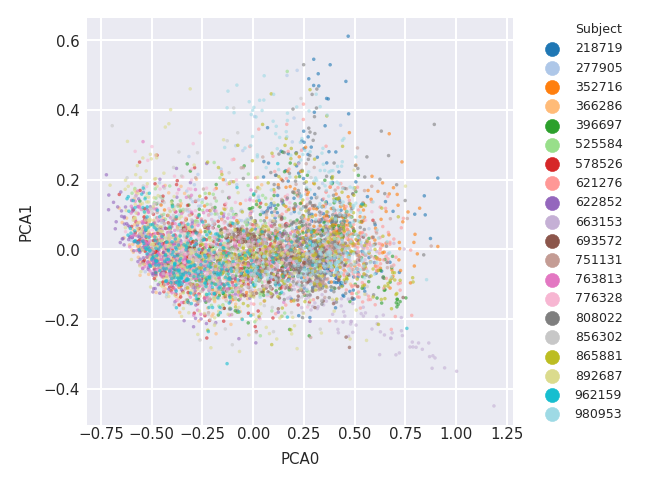

In [19]:
plot_pca(deep_features_train)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-pca-train.pdf")

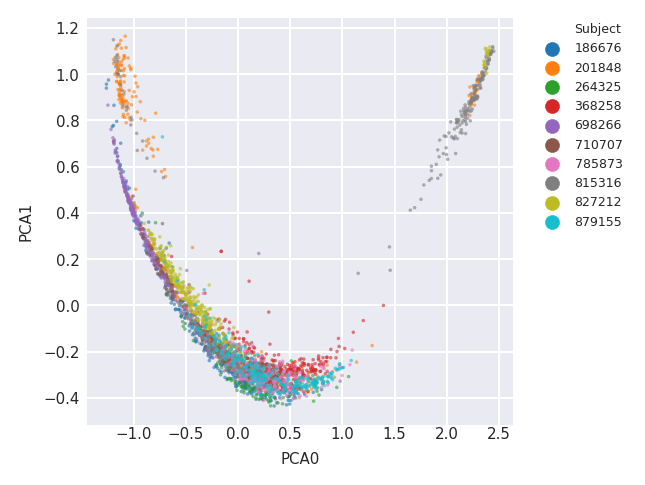

In [20]:
plot_pca(deep_features_test)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-pca-test.pdf")

In [ ]:
### Cleanup memory
%reset_selective -f df_
%reset_selective -f X_
%reset_selective -f y_
%reset_selective -f pca

## 6. OCSVM <a id='6'>&nbsp;</a> 

### 6.1 Load cached Data <a id='6.1'>&nbsp;</a> 

,X,subject,session,task_type
0,"((-8.607810569636623, 0.9955167241816556, -1.9...",186676,186676_session_1,4
1,"((-0.3209477333333335, 3.128859958333334, 9.44...",186676,186676_session_1,4
2,"((-2.057314, 4.621461133928572, 7.006203626785...",186676,186676_session_1,4
3,"((0.534176783756579, 6.0081232518346415, 8.295...",186676,186676_session_1,4
4,"((-1.53348510239776, 5.71207867121504, 8.14309...",186676,186676_session_1,4


### 6.2 Load trained Siamese Model <a id='6.2'>&nbsp;</a> 

**Helper methods to load model:**

,X,subject,session,task_type
0,"((-8.607810569636623, 0.9955167241816556, -1.9...",186676,186676_session_1,4
1,"((-0.3209477333333335, 3.128859958333334, 9.44...",186676,186676_session_1,4
2,"((-2.057314, 4.621461133928572, 7.006203626785...",186676,186676_session_1,4
3,"((0.534176783756579, 6.0081232518346415, 8.295...",186676,186676_session_1,4
4,"((-1.53348510239776, 5.71207867121504, 8.14309...",186676,186676_session_1,4


**Sanity Check:**

### 6.3 Search for Parameters <a id='6.3'>&nbsp;</a> 

In [15]:
df_ocsvm_train_valid.head()

,X,subject,session,task_type
0,"((-8.607810569636623, 0.9955167241816556, -1.9...",186676,186676_session_1,4
1,"((-0.3209477333333335, 3.128859958333334, 9.44...",186676,186676_session_1,4
2,"((-2.057314, 4.621461133928572, 7.006203626785...",186676,186676_session_1,4
3,"((0.534176783756579, 6.0081232518346415, 8.295...",186676,186676_session_1,4
4,"((-1.53348510239776, 5.71207867121504, 8.14309...",186676,186676_session_1,4


In [17]:
param_dist = {"gamma": np.logspace(-3, 3), "nu": np.linspace(0.0001, 0.3)}

# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with randomsearch scores

for run in tqdm(range(3)):
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_valid,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED + run,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_valid["subject"].nunique(),
        leave=False,
    ):

        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_valid_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = OneClassSVM(kernel="rbf")

        warnings.filterwarnings("ignore")
        random_search = RandomizedSearchCV(
            model,
            param_distributions=param_dist,
            cv=train_valid_cv,
            n_iter=80,
            n_jobs=CORES,
            refit=False,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            verbose=0,
            return_train_score=False,
            iid=False,
            error_score=np.nan,
            random_state=SEED,
        )

        random_search.fit(X, y)

        df_report = utils_cv_report(random_search, owner, impostors)
        df_report["run"] = run
        df_results = pd.concat([df_results, df_report], sort=False)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_random_search_results.csv", index=False)

KeyboardInterrupt: 

# etahoun edit here - trying out the VAE model on deep features! 


# PYOD 
### https://pyod.readthedocs.io/en/latest/pyod.models.html#pyod.models.vae.VAE 

In [10]:
from pyod.models.vae import VAE
from keras import losses
from keras import activations


VAE_param_dist = {
                #"l2_regularizer" :  np.linspace(1, 0,5) ,
                "contamination" :   np.linspace(.5, 0,5) ,
                "dropout_rate" :  np.linspace(1, 0,5) ,
                "optimizer" : ['adam', 'sgd'], 
    
                "batch_size" :  np.arange(0,64,16),
                "epochs" : np.arange(100,300,50),
                "gamma" : np.linspace(1, 0,5) , 
                "loss": [losses.mse, losses.msle, losses.poisson, losses.mape, losses.mae, losses.kld] , 
                "output_activation": [ activations.relu, activations.sigmoid, activations.softmax, activations.softplus,
                                      activations.softsign, activations.tanh, activations.selu, activations.elu, activations.exponential],
                "hidden_activation": [ activations.relu, activations.sigmoid, activations.softmax, activations.softplus,
                                      activations.softsign, activations.tanh, activations.selu, activations.elu, activations.exponential]

                 }

# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

vae_df_results = None  # Will be filled with randomsearch scores

for run in tqdm(range(1)):
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_valid,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED + run,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_valid["subject"].nunique(),
        leave=False,
    ):

        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_valid_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = VAE([32,16,8,4,2],[2,4,8,16,32])#VA()

        warnings.filterwarnings("ignore")
        random_search = RandomizedSearchCV(
            model,
            param_distributions=VAE_param_dist,
            cv=train_valid_cv,
            n_iter=80,
            n_jobs=CORES,
            refit=False,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            verbose=0,
            return_train_score=False,
            iid=False,
            error_score=np.nan,
            random_state=SEED,
        )

        random_search.fit(X, y)

        vae_df_report = utils_cv_report(random_search, owner, impostors)
        vae_df_report["run"] = run
        vae_df_results = pd.concat([vae_df_results, vae_df_report], sort=False)

vae_df_results.to_csv(OUTPUT_PATH / f"VAE_hyperparam_random_search_results.csv", index=False)

OSError: Unable to open file (unable to open file: name = '/gpfs/fs0/scratch/u/uhengart/ezzeldi/vae_hmog/ContinAuth/notebooks/output/chapter-6-1-4-siamese-cnn/NAIVE-MINMAX-2D_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# has to be in the 0.1 range 
#### [32,16,8,4,2],[2,4,8,16,32]
#### hyper param search 

In [ ]:
vae_df_results.nsmallest(3,['mean_test_eer'])['mean_test_eer'] 

# has to be in the 0.1 range 
#### [32,16,1],[1,16,32]

In [5]:
vae_df_results.nsmallest(3,['mean_test_eer'])['mean_test_eer'] #0.5s 

47    0.515750
30    0.516348
0     0.517034
Name: mean_test_eer, dtype: float64

# has to be in the 0.1 range 
#### [32,16,8,4,2,1],[1,2,4,8,16,32]

In [3]:
vae_df_results.nsmallest(3,['mean_test_eer'])['mean_test_eer'] # 0.5s 

NameError: name 'vae_df_results' is not defined

In [11]:
vae_df_results.nlargest(3,'mean_test_accuracy')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dropout_rate,879155_test_eer,785873_test_eer,201848_test_eer,368258_test_eer,710707_test_eer,186676_test_eer,827212_test_eer,815316_test_eer,698266_test_eer,mean_test_eer,std_test_eer,rank_test_eer,879155_test_accuracy,785873_test_accuracy,201848_test_accuracy,368258_test_accuracy,710707_test_accuracy,186676_test_accuracy,827212_test_accuracy,815316_test_accuracy,698266_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,264325_test_eer,264325_test_accuracy
7,17.860342,0.348101,0.021206,0.007499,7.19922,0.716981,0.714286,0.481481,0.541667,0.700000,0.698113,NaN,0.698113,0.724138,0.660161,0.082144,7.0,0.178571,0.190476,0.190476,0.190476,0.190476,0.190476,NaN,0.190476,0.190476,0.189153,0.003741,1,827212,0,0.666667,0.190476
23,17.329813,0.893444,0.023224,0.017802,3.39689,0.703704,0.714286,0.500000,0.541667,0.673469,0.698113,NaN,0.698113,0.724138,0.660819,0.076595,8.0,0.190476,0.190476,0.178571,0.190476,0.190476,0.190476,NaN,0.190476,0.190476,0.187831,0.004949,2,827212,0,0.693878,0.178571
25,17.244737,1.126536,0.020744,0.011925,3.09247,0.703704,0.714286,0.481481,0.541667,0.700000,0.711538,NaN,0.698113,0.736842,0.661589,0.083243,11.0,0.190476,0.190476,0.190476,0.190476,0.190476,0.178571,NaN,0.190476,0.178571,0.187831,0.004949,2,827212,0,0.666667,0.190476


In [5]:
vae_df_results.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dropout_rate,879155_test_eer,785873_test_eer,201848_test_eer,368258_test_eer,710707_test_eer,186676_test_eer,827212_test_eer,815316_test_eer,698266_test_eer,mean_test_eer,std_test_eer,rank_test_eer,879155_test_accuracy,785873_test_accuracy,201848_test_accuracy,368258_test_accuracy,710707_test_accuracy,186676_test_accuracy,827212_test_accuracy,815316_test_accuracy,698266_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,264325_test_eer,264325_test_accuracy
0,5.385456,0.109778,0.006919,0.000767,0.1,0.544118,0.506849,0.685185,0.578125,0.500000,0.660714,0.672727,0.506849,0.552239,0.578534,0.070963,1.0,0.059524,0.059524,0.059524,0.059524,0.059524,0.059524,0.059524,0.059524,0.059524,0.059524,0.0,1,264325,0,NaN,NaN
1,5.278829,0.109853,0.006720,0.001194,0.2,0.544118,0.506849,0.685185,0.578125,0.500000,0.660714,0.672727,0.506849,0.552239,0.578534,0.070963,1.0,0.059524,0.059524,0.059524,0.059524,0.059524,0.059524,0.059524,0.059524,0.059524,0.059524,0.0,1,264325,0,NaN,NaN
0,5.351207,0.073102,0.007158,0.000863,0.1,NaN,0.520548,0.883721,0.703704,0.575758,0.808511,0.690909,0.745098,0.913043,0.715005,0.129077,1.0,NaN,0.047619,0.047619,0.047619,0.047619,0.047619,0.047619,0.047619,0.047619,0.047619,0.0,1,879155,0,0.593750,0.047619
1,5.365671,0.068319,0.007742,0.000894,0.2,NaN,0.520548,0.883721,0.703704,0.575758,0.808511,0.690909,0.745098,0.913043,0.715005,0.129077,1.0,NaN,0.047619,0.047619,0.047619,0.047619,0.047619,0.047619,0.047619,0.047619,0.047619,0.0,1,879155,0,0.593750,0.047619
0,5.367753,0.075988,0.007536,0.001005,0.1,0.558824,NaN,0.760000,0.655172,0.550725,0.593750,0.808511,0.666667,0.678571,0.650759,0.084294,1.0,0.047619,NaN,0.047619,0.047619,0.047619,0.047619,0.047619,0.047619,0.047619,0.047619,0.0,1,785873,0,0.584615,0.047619


In [26]:
df_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nu,param_gamma,879155_test_eer,785873_test_eer,201848_test_eer,368258_test_eer,710707_test_eer,186676_test_eer,827212_test_eer,815316_test_eer,698266_test_eer,mean_test_eer,std_test_eer,rank_test_eer,879155_test_accuracy,785873_test_accuracy,201848_test_accuracy,368258_test_accuracy,710707_test_accuracy,186676_test_accuracy,827212_test_accuracy,815316_test_accuracy,698266_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,264325_test_eer,264325_test_accuracy
0,0.002134,0.000763,0.003451,0.001133,0.208194,0.0167683,0.288889,0.516667,0.254902,0.288889,0.452830,0.355556,0.250000,0.408163,0.395833,0.356859,0.088164,40.0,0.726190,0.476190,0.797619,0.726190,0.559524,0.654762,0.809524,0.607143,0.619048,0.664021,0.104506,41,264325,0,NaN,NaN
1,0.005192,0.001805,0.007316,0.002563,0.257157,568.987,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,74.0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,74,264325,0,NaN,NaN
2,0.001942,0.000819,0.002949,0.000976,0.110267,0.00409492,0.280000,0.478261,0.162791,0.234043,0.446154,0.345455,0.162791,0.368421,0.437500,0.323935,0.113548,7.0,0.761905,0.535714,0.845238,0.797619,0.583333,0.702381,0.845238,0.678571,0.595238,0.705026,0.109221,5,264325,0,NaN,NaN
3,0.003825,0.004022,0.004067,0.001840,0.0429429,0.868511,0.421875,0.486111,0.327273,0.362069,0.471429,0.421875,0.274510,0.372881,0.439394,0.397491,0.065133,62.0,0.619048,0.523810,0.726190,0.690476,0.547619,0.619048,0.773810,0.678571,0.595238,0.641534,0.077649,58,264325,0,NaN,NaN
4,0.002742,0.001616,0.004073,0.002563,0.0429429,2.6827,0.419355,0.485714,0.280000,0.345455,0.478261,0.409836,0.280000,0.368421,0.379310,0.382928,0.070333,54.0,0.619048,0.523810,0.761905,0.702381,0.535714,0.630952,0.761905,0.678571,0.666667,0.653439,0.081023,50,264325,0,NaN,NaN


In [ ]:
vae_df_results.head()

In [62]:
df_report = pd.DataFrame(random_search.cv_results_)
df_report.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000208,0.000007,0.0,0.0,10,{'learning_rate': 10.0},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,0.000208,0.000007,0.0,0.0,9.5414,{'learning_rate': 9.541403118120238},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27
2,0.000215,0.000015,0.0,0.0,9.10384,{'learning_rate': 9.103837346247461},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28
3,0.000200,0.000034,0.0,0.0,8.68634,{'learning_rate': 8.6863382042345},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29
4,0.000208,0.000009,0.0,0.0,8.28799,{'learning_rate': 8.287985442693001},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30


In [85]:
vae_df_results = pd.read_csv(OUTPUT_PATH / f"VAE_random_search_results.csv")
print("Best results for each owner:")

display(
    vae_df_results[df_results["rank_test_eer"] <= 1][
        [
            "owner",
            "param_learning_rate",
            "rank_test_eer",
            "mean_test_eer",
            "std_test_eer",
            "mean_test_accuracy",
            "std_test_accuracy",
        ]
    ].sort_values("mean_test_eer").head(10)
)

FileNotFoundError: [Errno 2] File b'/gpfs/fs0/scratch/u/uhengart/ezzeldi/ContinAuth/notebooks/output/chapter-6-1-4-siamese-cnn/MLP_random_search_results.csv' does not exist: b'/gpfs/fs0/scratch/u/uhengart/ezzeldi/ContinAuth/notebooks/output/chapter-6-1-4-siamese-cnn/MLP_random_search_results.csv'

In [17]:
VAE_model.get_params().keys()

dict_keys(['batch_size', 'continuous', 'learning_rate', 'n_components_decoder', 'n_components_encoder', 'n_hidden_variables', 'n_iter', 'random_state', 'sampling_rounds', 'verbose'])

In [34]:
"""SGVB
"""
# Authors: Joost van Amersfoort <joost.van.amersfoort@gmail.com>
#          Otto Fabius <ottofabius@gmail.com>
#          
# License: MIT

import time
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.externals.six.moves import xrange
from sklearn.utils import check_array, check_random_state, gen_even_slices #atleast2d_or_csr


class VA(BaseEstimator, TransformerMixin):

    """Stochastic Gradient Variational Bayes
    An auto-encoder with variational Bayes inference.
    Parameters
    ----------
    n_components_decoder : int, optional
        Number of binary hidden units for decoder.
    n_components_encoder : int, optional
        Number of binary hidden units for encoder.
    n_hidden_variables : int, optional
        The dimensionality of Z
    learning_rate : float, optional
        The learning rate for weight updates. It is *highly* recommended
        to tune this hyper-parameter. Reasonable values are in the
        10**[0., -3.] range.
    batch_size : int, optional
        Number of examples per minibatch.
    n_iter : int, optional
        Number of iterations/sweeps over the training dataset to perform
        during training.
    sampling_rounds : int, optional
        Number of sampling rounds done on the minibatch
    continuous : boolean, optional
        Set what type of data the auto-encoder should model
    verbose : int, optional
        The verbosity level. The default, zero, means silent mode.
    random_state : integer or numpy.RandomState, optional
        A random number generator instance to define the state of the
        random permutations generator. If an integer is given, it fixes the
        seed. Defaults to the global numpy random number generator.
    Attributes
    ----------
    'params' : list-like, list of weights and biases.
    Examples
    --------
    ----------
    References
    [1] Kingma D.P., Welling M. Stochastic Gradient VB and the Variational Auto-Encoder
    Arxiv, preprint. http://arxiv.org/pdf/1312.6114v6.pdf
    """

    def __init__(self, n_components_decoder=200, n_components_encoder=200,
                 n_hidden_variables=20, learning_rate=0.02, batch_size=100,
                 n_iter=40, sampling_rounds=1, continuous=False, verbose=0,
                 random_state=None,nu=None):
        self.n_components_decoder = n_components_decoder
        self.n_components_encoder = n_components_encoder
        self.n_hidden_variables = n_hidden_variables

        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_iter = n_iter
        self.sampling_rounds = sampling_rounds
        self.verbose = verbose

        self.continuous = continuous
        self.random_state = random_state

    def _initParams(self, dimX, rng):
        """Create all weight and bias parameters with the right dimensions
        Parameters
        ----------
        dimX : scalar
            The dimensionality of the input data X
        """
        sigmaInit = 0.01
        W1 = rng.normal(0, sigmaInit, (self.n_components_encoder, dimX))
        b1 = rng.normal(0, sigmaInit, (self.n_components_encoder, 1))

        W2 = rng.normal(
            0, sigmaInit, (self.n_hidden_variables, self.n_components_encoder))
        b2 = rng.normal(0, sigmaInit, (self.n_hidden_variables, 1))

        W3 = rng.normal(
            0, sigmaInit, (self.n_hidden_variables, self.n_components_encoder))
        b3 = rng.normal(0, sigmaInit, (self.n_hidden_variables, 1))

        W4 = rng.normal(
            0, sigmaInit, (self.n_components_decoder, self.n_hidden_variables))
        b4 = rng.normal(0, sigmaInit, (self.n_components_decoder, 1))

        W5 = rng.normal(0, sigmaInit, (dimX, self.n_components_decoder))
        b5 = rng.normal(0, sigmaInit, (dimX, 1))

        self.params = {"W1": W1, "W2": W2, "W3": W3, "W4": W4, "W5": W5,
                        "b1": b1, "b2": b2, "b3": b3, "b4": b4, "b5": b5}

        if self.continuous:
            W6 = rng.normal(
                0, sigmaInit, (dimX, self.n_components_decoder))
            b6 = rng.normal(0, sigmaInit, (dimX, 1))
            self.params.update({"W6": W6, "b6": b6})

        self.h = dict()
        for key in self.params:
            self.h[key] = 0.01

    def _initH(self, minibatch, rng):
        """Initialize H for AdaGrad
        Parameters
        ----------
        minibatch: array-like, shape (n_features, batch_size)
            The data to use for computing gradients to update H
        """

    
        gradients, lowerbound = self._computeGradients(minibatch.T, rng)

        for key in gradients:
            self.h[key] += gradients[key] ** 2

    def _computeGradients(self, x, rng):
        """Perform backpropagation
        Parameters
        ----------
        x: array-like, shape (n_features, batch_size)
            The data to use for computing gradients to update the weights and biases
        Returns
        -------
        gradients : dictionary with ten or twelve array-like gradients to the weights and biases
        lowerbound : int
            Lower bound on the log likelihood per data point
        """
        W1, W2, W3, W4, W5 = self.params["W1"], self.params["W2"], self.params["W3"],\
        self.params["W4"], self.params["W5"]
        b1, b2, b3, b4, b5 = self.params["b1"], self.params["b2"], self.params["b3"],\
        self.params["b4"], self.params["b5"]

        if self.continuous:
            W6, b6 = self.params["W6"], self.params["b6"]
            activation = lambda x: np.log(1 + np.exp(x))
        else:
            activation = lambda x: np.tanh(x,x)

        sigmoid = lambda x: 1. / (1 + np.exp(-x))

        #Feed forward
        h_encoder = activation(W1.dot(x) + b1)

        mu_encoder = W2.dot(h_encoder) + b2
        log_sigma_encoder = 0.5 * (W3.dot(h_encoder) + b3)

        eps = rng.normal(0, 1, [self.n_hidden_variables, x.shape[1]])
        z = mu_encoder + np.exp(log_sigma_encoder) * eps

        h_decoder = activation(W4.dot(z) + b4)

        y = sigmoid(W5.dot(h_decoder) + b5)

        if self.continuous:
            log_sigma_decoder = 0.5 * (W6.dot(h_decoder) + b6)
            logpxz = np.sum(-(0.5 * np.log(2 * np.pi) + log_sigma_decoder) -
                            0.5 * ((x - y) / np.exp(log_sigma_decoder)) ** 2)
        else:
            logpxz = np.sum(x * np.log(y) + (1 - x) * np.log(1 - y))

        KLD = 0.5 * np.sum(1 + 2 * log_sigma_encoder -
                           mu_encoder ** 2 - np.exp(2 * log_sigma_encoder))
        lowerbound = logpxz + KLD

        # Compute gradients
        if self.continuous:
            dp_dy = (np.exp(-2 * log_sigma_decoder) * 2 * (x - y)) / 2
            dp_dlogsigd = np.exp(-2 * log_sigma_decoder) * (x - y) ** 2 - 1
        else:
            dp_dy = (x / y - (1 - x) / (1 - y))

        # W5
        dy_dSig = (y * (1 - y))
        dp_dW5 = (dp_dy * dy_dSig).dot(h_decoder.T)
        dp_db5 = np.sum(dp_dy * dy_dSig, axis=1, keepdims=True)

        if self.continuous:
            # W6
            dp_dW6 = (dp_dlogsigd * dy_dSig).dot(0.5 * h_decoder.T)
            dp_db6 = np.sum(dp_dlogsigd * dy_dSig, axis=1, keepdims=True)

        dSig_dHd = W5
        dp_dHd = ((dp_dy * dy_dSig).T.dot(dSig_dHd)).T

        if self.continuous:
            dHd_df = np.exp(W4.dot(z) + b4) / (np.exp(W4.dot(z) + b4) + 1)
        else:
            dHd_df = 1 - h_decoder ** 2

        # W4
        dp_dW4 = (dp_dHd * dHd_df).dot(z.T)
        dp_db4 = np.sum(dp_dHd * dHd_df, axis=1, keepdims=True)

        dtanh_dz = W4
        dmue_dW2 = h_encoder

        dp_dz = (dp_dHd * dHd_df).T.dot(dtanh_dz)
        dp_dmue = dp_dz.T

        dp_dW2 = dp_dmue.dot(dmue_dW2.T)
        dp_db2 = dp_dmue

        dKLD_dmue = -mu_encoder
        dKLD_dW2 = dKLD_dmue.dot(dmue_dW2.T)
        dKLD_db2 = dKLD_dmue

        # W2
        dp_dW2 += dKLD_dW2
        dp_db2 = np.sum(dp_db2 + dKLD_db2, axis=1, keepdims=True)

        dz_dlogsige = eps * np.exp(log_sigma_encoder)
        dp_dlogsige = dp_dz.T * dz_dlogsige

        dlogsige_dW3 = 0.5 * h_encoder
        dlogsige_db3 = 0.5

        dp_dW3 = dp_dlogsige.dot(dlogsige_dW3.T)
        dp_db3 = dp_dlogsige * dlogsige_db3

        dKLD_dlogsige = 1 - np.exp(2 * log_sigma_encoder)
        dKLD_dW3 = dKLD_dlogsige.dot(dlogsige_dW3.T)
        dKLD_db3 = dKLD_dlogsige * dlogsige_db3

        # W3
        dp_dW3 += dKLD_dW3
        dp_db3 = np.sum(dp_db3 + dKLD_db3, axis=1, keepdims=True)

        # W1, log p(x|z)
        ###########################################
        dmue_dHe = W2
        if self.continuous:
            dHe_df = np.exp(W1.dot(x) + b1) / (np.exp(W1.dot(x) + b1) + 1)
        else:
            dHe_df = 1 - h_encoder ** 2

        dtanh_dW1 = x

        # W1: log(P(x|z)), mu encoder side
        dp_dHe = dp_dmue.T.dot(dmue_dHe)
        dp_dtanh = dp_dHe.T * dHe_df
        dp_dW1_1 = (dp_dtanh).dot(dtanh_dW1.T)
        dp_db1_1 = dp_dtanh

        # W1: log(P(x|z)), log sigma encoder side
        dlogsige_dHe = 0.5 * W3
        dp_dHe_2 = dp_dlogsige.T.dot(dlogsige_dHe)

        dp_dtanh_2 = dp_dHe_2.T * dHe_df
        dp_dW1_2 = (dp_dtanh_2).dot(dtanh_dW1.T)
        dp_db1_2 = dp_dtanh_2

        dp_dW1 = dp_dW1_1 + dp_dW1_2
        dp_db1 = dp_db1_1 + dp_db1_2
        ##########################################

        #W1, DKL
        ###########################################
        dKLD_dHe_1 = dKLD_dlogsige.T.dot(dlogsige_dHe)
        dKLD_dHe_2 = dKLD_dmue.T.dot(dmue_dHe)

        dKLD_dtanh = dKLD_dHe_1.T * dHe_df
        dKLD_dW1_1 = (dKLD_dtanh).dot(dtanh_dW1.T)
        dKLD_db1_1 = dKLD_dtanh

        dKLD_dtanh_2 = dKLD_dHe_2.T * dHe_df
        dKLD_dW1_2 = (dKLD_dtanh_2).dot(dtanh_dW1.T)
        dKLD_db1_2 = dKLD_dtanh_2

        dKLD_dW1 = dKLD_dW1_1 + dKLD_dW1_2
        dKLD_db1 = dKLD_db1_1 + dKLD_db1_2
        ############################################

        # W1
        dp_dW1 += dKLD_dW1
        dp_db1 = np.sum(dp_db1 + dKLD_db1, axis=1, keepdims=True)

        gradients = {"W1": dp_dW1, "W2": dp_dW2, "W3": dp_dW3, "W4": dp_dW4, "W5": dp_dW5,
                     "b1": dp_db1, "b2": dp_db2, "b3": dp_db3, "b4": dp_db4, "b5": dp_db5}

        if self.continuous:
            gradients.update({"W6": dp_dW6, "b6": dp_db6})

        return [gradients, lowerbound]

    def _updateParams(self, minibatch, N, rng):
        """Perform one update on the parameters
        Parameters
        ----------
        minibatch : array-like, shape (n_features, batch_size)
            The data to use for computing gradients to update the weights and biases
        N : int
            The total number of datapoints, used for prior correction
        Returns
        -------
        lowerbound : int
            Lower bound on the log likelihood per data point
        """
        for l in xrange(self.sampling_rounds):
            gradients, lowerbound = self._computeGradients(minibatch.T, rng)

            if 'total_gradients' not in locals():
                total_gradients = gradients
            else:
                for key in gradients:
                    total_gradients[key] += gradients[key]

        for key in self.params:
            self.h[key] += total_gradients[key] ** 2
            if "W" in key:
                prior = 0.5 * self.params[key]
            else:
                prior = 0

            self.params[key] += self.learning_rate / np.sqrt(self.h[key]) * \
                (total_gradients[key] - prior * (minibatch.shape[0] / N))

        return lowerbound

    def fit(self, X,y):
        """Fit SGVB to the data
        Parameters
        ----------
        X : array-like, shape (N, n_features)
            The data that the SGVB needs to fit on
        Returns
        -------
        list_lowerbound : list of int
        list of lowerbound over time
        """
        X = check_array(X, accept_sparse='csr')#, dtype=np.float)
        [N, dimX] = X.shape
        rng = check_random_state(self.random_state)

        self._initParams(dimX, rng)
        list_lowerbound = np.array([])

        n_batches = int(np.ceil(float(N) / self.batch_size))
        batch_slices = list(gen_even_slices(n_batches * self.batch_size,
                                            n_batches, N))

        if self.verbose:
            print ("Initializing gradients for AdaGrad")
        for i in xrange(len(batch_slices)):
            self._initH(X[batch_slices[i]], rng)

        begin = time.time()
        for iteration in xrange(1, self.n_iter + 1):
            iteration_lowerbound = 0

            for batch_slice in batch_slices:
                lowerbound = self._updateParams(X[batch_slice], N, rng)
                iteration_lowerbound += lowerbound

            if self.verbose:
                end = time.time()
                print("[%s] Iteration %d, lower bound = %.2f,"
                      " time = %.2fs"
                      % (self.__class__.__name__, iteration,
                         iteration_lowerbound / N, end - begin))
                begin = end

            list_lowerbound = np.append(
                list_lowerbound, iteration_lowerbound / N)
        return list_lowerbound

    def transform(self, X):
        """Transform the data
        Parameters
        ----------
        X : array-like, shape (N, n_features)
            The data that needs to be transformed
        Returns
        -------
        X : array-like, shape (N, n_components_decoder)
            The transformed data
        """
        X, = check_array(X, accept_sparse='csr')#, dtype=np.float)

        if self.continuous:
            return np.log(1 + np.exp(X.dot(self.params["W1"].T) + self.params["b1"].T))
        else:
            return np.tanh(X.dot(self.params["W1"].T) + self.params["b1"].T)

    def fit_transform(self, X):
        """Fit and transform the data, wrapper for fit and transform
        Parameters
        ----------
        X : array-like, shape (N, n_features)
            The data that needs to be fitted to and transformed
        Returns
        -------
        X : array-like, shape (N, n_components_decoder)
            The transformed data
        """
        self.fit(X)
        return self.transform(X)

    def score(self, X,y):
        """Computer lower bound on data, very naive implementation
        Parameters
        ----------
        data : array-like, shape (N, n_features)
            The data that needs to be fitted to and transformed
        Returns
        -------
        lower bound : int
            The lower bound on the log likelihood 
        """
        v = check_array(X)
        rng = check_random_state(self.random_state)

        gradients, lowerbound = self._computeGradients(v.T, rng)
        return lowerbound/X.shape[0]

# experimenting here yet again

In [ ]:
X.shape

In [ ]:
# Shape of input and latent variable

n_input = 28*28

# Encoder structure
n_encoder1 = 500
n_encoder2 = 300

n_latent = 2

# Decoder structure
n_decoder2 = 300
n_decoder1 = 500

reg = MLPRegressor(hidden_layer_sizes = (n_encoder1, n_encoder2, n_latent, n_decoder2, n_decoder1), 
                   activation = 'tanh', 
                   solver = 'adam', 
                   learning_rate_init = 0.0001, 
                   max_iter = 20, 
                   tol = 0.0000001, 
                   verbose = True)



In [3]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})
							 

In [ ]:
def train(network_architecture, learning_rate=0.001,
              batch_size=100, training_epochs=10, display_step=5):
        vae = VariationalAutoencoder(network_architecture, 
                                     learning_rate=learning_rate, 
                                     batch_size=batch_size)
        # Training cycle
        for epoch in range(training_epochs):
            avg_cost = 0.
            total_batch = int(n_samples / batch_size)
            # Loop over all batches
            for i in range(total_batch):
                batch_xs, _ = mnist.train.next_batch(batch_size)

                # Fit training using batch data
                cost = vae.partial_fit(batch_xs)
                # Compute average loss
                avg_cost += cost / n_samples * batch_size

            # Display logs per epoch step
            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), 
                      "cost=", "{:.9f}".format(avg_cost))
        return vae

In [8]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

def create_vae_model(learning_rate=0.001,
              batch_size=100, training_epochs=75, display_step=5):
        network_architecture = \
        dict(n_hidden_recog_1=500, # 1st layer encoder neurons
             n_hidden_recog_2=500, # 2nd layer encoder neurons
             n_hidden_gener_1=500, # 1st layer decoder neurons
             n_hidden_gener_2=500, # 2nd layer decoder neurons
             n_input=784, # MNIST data input (img shape: 28*28)
             n_z=20)  # dimensionality of latent space

        
        vae = VariationalAutoencoder(network_architecture, 
                                     learning_rate=learning_rate, 
                                     batch_size=batch_size)
        
        return vae

In [10]:
!pip uninstall tensorflow

In [16]:
!pip install tensorflow==1.0.0

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement tensorflow==1.0.0 (from versions: none)
ERROR: No matching distribution found for tensorflow==1.0.0


In [9]:
__model = create_vae_model()

AttributeError: module 'tensorflow' has no attribute 'mul'

In [31]:
len(train_valid_cv[4][1])
#9 every one has a tuple of 126 adnd 84 

84

In [32]:
owner

'264325'

In [34]:
impostors

['879155',
 '785873',
 '201848',
 '368258',
 '710707',
 '186676',
 '827212',
 '815316',
 '698266']

In [17]:

import scipy
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest


param_dist = {"gamma": np.logspace(-3, 3), "nu": np.linspace(0.0001, 0.3)} #ocsvm 
param_dist = {"n_estimators": np.arange(start=1, stop=100, step=5), "max_features": np.arange(start=1, stop=500, step=5.5)} #if
param_dist = {"n_neighbors": np.arange(start=1, stop=100, step=1), "p":np.arange(start=1, stop=4, step=1),"leaf_size": np.arange(start=1, stop=100, step=1)} #lof
param_dist = {
    'solver': ['sgd', 'adam', 'lbfgs'],
    'activation': ['relu', 'tanh'],
    'learning_rate':['constant', 'invscaling', 'adaptive'],
    'alpha':np.linspace(0.0001, 0.3), 
    'momentum':np.linspace(0.0001, 0.99)
    
} #mlp 




# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with randomsearch scores

for run in tqdm(range(1)):
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_valid,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED + run,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_valid["subject"].nunique(),
        leave=False,
    ):

        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_valid_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)
        network_architecture = \
        dict(n_hidden_recog_1=500, # 1st layer encoder neurons
             n_hidden_recog_2=500, # 2nd layer encoder neurons
             n_hidden_gener_1=500, # 1st layer decoder neurons
             n_hidden_gener_2=500, # 2nd layer decoder neurons
             n_input=784, # MNIST data input (img shape: 28*28)
             n_z=20)  # dimensionality of latent space
        
        
        #model = VariationalAutoencoder() #MLPClassifier()#LocalOutlierFactor(novelty=True)#OneClassSVM(kernel="rbf")#IsolationForest()#
        model = create_vae_model()

        warnings.filterwarnings("ignore")
        random_search = RandomizedSearchCV(
            model,
            param_distributions=param_dist,
            cv=train_valid_cv,
            n_iter=80,
            n_jobs=CORES,
            refit=False,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            verbose=0,
            return_train_score=False,
            iid=False,
            error_score=np.nan,
            random_state=SEED,
        )

        random_search.fit(X, y)

        df_report = utils_cv_report(random_search, owner, impostors)
        df_report["run"] = run
        df_results = pd.concat([df_results, df_report], sort=False)

df_results.to_csv(OUTPUT_PATH / f"MLP_{P.name}_random_search_results.csv", index=False)

AttributeError: module 'tensorflow' has no attribute 'mul'

# vae 3 layers 

In [6]:
vae_df_results.nsmallest(3,['mean_test_eer'])['mean_test_eer']

0    0.503553
1    0.503553
0    0.559342
Name: mean_test_eer, dtype: float64

# mlp with parm 

In [ ]:
df_results.nsmallest(3,['mean_test_eer'])['mean_test_eer']

# ocsvm with parm 

In [98]:
df_results.nsmallest(3,['mean_test_eer'])['mean_test_eer']

5     0.134706
55    0.135051
76    0.155198
Name: mean_test_eer, dtype: float64

# ocsvm

In [96]:
df_results.nsmallest(3,['mean_test_eer'])['mean_test_eer']

0    0.317921
0    0.337775
0    0.359286
Name: mean_test_eer, dtype: float64

# if with param with bootstrap

In [103]:
df_results.nsmallest(3,['mean_test_eer'])['mean_test_eer']

74    0.228189
74    0.333581
74    0.334576
Name: mean_test_eer, dtype: float64

# if with param

In [100]:
df_results.nsmallest(3,['mean_test_eer'])['mean_test_eer']

74    0.216643
74    0.311115
74    0.339354
Name: mean_test_eer, dtype: float64

# if

In [94]:
df_results.nsmallest(3,['mean_test_eer'])['mean_test_eer']

0    0.213700
0    0.295690
0    0.320379
Name: mean_test_eer, dtype: float64

# lof

In [88]:
df_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,879155_test_eer,785873_test_eer,201848_test_eer,368258_test_eer,710707_test_eer,186676_test_eer,827212_test_eer,815316_test_eer,698266_test_eer,mean_test_eer,std_test_eer,rank_test_eer,879155_test_accuracy,785873_test_accuracy,201848_test_accuracy,368258_test_accuracy,710707_test_accuracy,186676_test_accuracy,827212_test_accuracy,815316_test_accuracy,698266_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,264325_test_eer,264325_test_accuracy
0,0.003796,0.000074,0.004981,0.000204,0.357143,0.485714,0.127660,0.200000,0.428571,0.437500,0.250000,0.492958,0.446154,0.358411,0.126175,1.0,0.690476,0.523810,0.916667,0.821429,0.607143,0.595238,0.785714,0.511905,0.583333,0.670635,0.133748,1,264325,0,NaN,NaN
0,0.003668,0.000048,0.005137,0.000112,NaN,0.389831,0.142857,0.294118,0.470588,0.250000,0.333333,0.280000,0.125000,0.294905,0.105926,1.0,NaN,0.654762,0.857143,0.750000,0.547619,0.785714,0.714286,0.761905,0.928571,0.742063,0.105737,1,879155,0,0.368421,0.678571
0,0.003671,0.000055,0.005270,0.000189,0.369565,NaN,0.276596,0.245283,0.516667,0.302326,0.276596,0.309524,0.270833,0.321441,0.076983,1.0,0.642857,NaN,0.750000,0.821429,0.476190,0.702381,0.750000,0.690476,0.761905,0.697090,0.092744,1,785873,0,0.325581,0.678571
0,0.003839,0.000058,0.005267,0.000141,0.403226,0.195652,NaN,0.519481,0.455882,0.212766,0.525641,0.439394,0.274510,0.382139,0.117662,1.0,0.642857,0.833333,NaN,0.464286,0.571429,0.821429,0.452381,0.595238,0.773810,0.642857,0.133748,1,201848,0,0.412698,0.630952
0,0.003773,0.000047,0.004970,0.000118,0.384615,0.196078,0.438596,NaN,0.255814,0.192308,0.407407,0.204082,0.200000,0.277903,0.096096,1.0,0.642857,0.869048,0.583333,NaN,0.750000,0.880952,0.619048,0.845238,0.857143,0.760582,0.110321,1,368258,0,0.222222,0.797619


# lof

In [91]:
df_results.nsmallest(3,['mean_test_eer'])['mean_test_eer']

0    0.193072
0    0.277903
0    0.283373
Name: mean_test_eer, dtype: float64

# lof with param

In [107]:
df_results.nsmallest(3,['mean_test_eer'])['mean_test_eer']

66    0.151011
50    0.151336
77    0.151477
Name: mean_test_eer, dtype: float64

In [ ]:
param_dist = {"gamma": np.logspace(-3, 3), "nu": np.linspace(0.0001, 0.3)}

# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with randomsearch scores

for run in tqdm(range(1)):
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_valid,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED + run,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_valid["subject"].nunique(),
        leave=False,
    ):

        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_valid_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        ''' model = OneClassSVM(kernel="rbf")

        warnings.filterwarnings("ignore")
        random_search = RandomizedSearchCV(
            model,
            param_distributions=param_dist,
            cv=train_valid_cv,
            n_iter=80,
            n_jobs=CORES,
            refit=False,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            verbose=0,
            return_train_score=False,
            iid=False,
            error_score=np.nan,
            random_state=SEED,
        )

        random_search.fit(X, y)
        '''
        df_report = utils_cv_report(random_search, owner, impostors)
        df_report["run"] = run
        df_results = pd.concat([df_results, df_report], sort=False)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_random_search_results.csv", index=False)

### 6.4 Inspect Search Results <a id='6.4'>&nbsp;</a> 
**Raw Results & Stats:**

In [26]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_random_search_results.csv")
print("Best results for each owner:")

display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "owner",
            "param_nu",
            "param_gamma",
            "rank_test_eer",
            "mean_test_eer",
            "std_test_eer",
            "mean_test_accuracy",
            "std_test_accuracy",
        ]
    ].sort_values("mean_test_eer").head(10)
)

print("\n\n\nMost relevant statistics:")
display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "mean_fit_time",
            "param_nu",
            "param_gamma",
            "mean_test_accuracy",
            "std_test_accuracy",
            "mean_test_eer",
            "std_test_eer",
        ]
    ].describe()
)

Best results for each owner:


,owner,param_nu,param_gamma,rank_test_eer,mean_test_eer,std_test_eer,mean_test_accuracy,std_test_accuracy
1938,368258,0.300000,3.556480,1.0,0.126146,0.060848,0.906085,0.039461
1605,827212,0.104147,8.286428,1.0,0.141555,0.108518,0.890212,0.104355
805,827212,0.104147,8.286428,1.0,0.150016,0.007585,0.890212,0.027365
1688,698266,0.244916,10.985411,1.0,0.156091,0.067556,0.880952,0.064232
1848,785873,0.244916,10.985411,1.0,0.176333,0.089694,0.862434,0.082881
356,368258,0.195953,0.372759,1.0,0.202416,0.100655,0.835979,0.089048
1456,698266,0.055184,19.306977,1.0,0.208330,0.049741,0.821429,0.058321
98,879155,0.300000,3.556480,1.0,0.214637,0.073716,0.816138,0.079980
1105,186676,0.263278,3.556480,1.0,0.221915,0.090269,0.809524,0.087302
2016,264325,0.055184,19.306977,1.0,0.243699,0.116344,0.785714,0.116777





Most relevant statistics:


,mean_fit_time,param_nu,param_gamma,mean_test_accuracy,std_test_accuracy,mean_test_eer,std_test_eer
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,0.001815,0.153110,14.228625,0.758870,0.086496,0.272894,0.078313
std,0.000543,0.092906,11.362225,0.074616,0.026868,0.072102,0.031528
min,0.000751,0.000100,0.002330,0.593915,0.027365,0.126146,0.007585
25%,0.001399,0.059774,3.556480,0.706349,0.072133,0.227361,0.050905
50%,0.001789,0.153110,10.985411,0.746693,0.081714,0.281459,0.076528
75%,0.002025,0.244916,25.595479,0.803571,0.105031,0.317481,0.104648
max,0.003070,0.300000,44.984327,0.906085,0.160909,0.417199,0.160257


**Plot parameters of top n of 30 results for every Owner:**

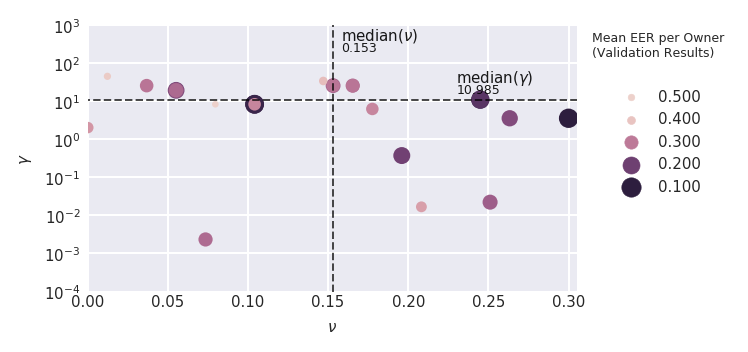

In [27]:
utils_plot_randomsearch_results(df_results, 1)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-parameters.pdf")

In [39]:
def vae_utils_plot_randomsearch_results(df_results, n_top=1):
    # Prepare data for plotting
    df_plot = df_results[df_results["rank_test_eer"] <= n_top].rename(
        columns={
            "param_n_hidden_variables": r"$\n_hidden_variables$",
            "param_learning_rate": r"$\learning_rate$",
            "mean_test_accuracy": "Mean Test Acc.",
            "mean_test_eer": "Mean Test EER",
        }
    )
    df_plot["Mean Test EER"] = df_plot["Mean Test EER"] * -1  # Because fewer is more

    median_n_hidden_variables = df_plot[r"$\n_hidden_variables$"].median()
    median_learning_rate = df_plot[r"$\learning_rate$"].median()

    # Plot
    fig = plt.figure(figsize=(5.473 / 1.3, 2), dpi=180)
    g = sns.scatterplot(
        x=r"$\n_hidden_variables$",
        y=r"$\learning_rate$",
        data=df_plot,
        size="Mean Test EER",
        sizes=(7, 60),
        hue="Mean Test EER",
        alpha=1,
        #        palette="Blues",
        linewidth=0,
    )

    # Format Legend labels
    leg = g.get_legend()
    new_handles = [h for h in leg.legendHandles]
    new_labels = []
    for i, handle in en_hidden_variablesmerate(leg.legendHandles):
        label = handle.get_label()
        try:
            new_labels.append(f"{abs(float(label)):.3f}")
        except ValueError:
            new_labels.append("")

    # Plot mean values
    plt.plot(
        [-0.01, 0.31],
        [median_learning_rate, median_learning_rate],
        linestyle="dashed",
        linewidth=0.8,
        alpha=0.7,
        color="black",
    )
    plt.text(
        0.23,
        median_learning_rate * 1.7 ** 2,
        r"median($\learning_rate$)",
        fontsize=6,
        color="black",
        alpha=0.9,
    )
    plt.text(
        0.23,
        median_learning_rate * 1.2 ** 2,
        f"{median_learning_rate:.3f}",
        fontsize=5,
        color="black",
        alpha=0.9,
    )

    plt.plot(
        [median_n_hidden_variables, median_n_hidden_variables],
        [0.0001, 1000],
        linestyle="dashed",
        linewidth=0.8,
        alpha=0.7,
        color="black",
    )
    plt.text(
        median_n_hidden_variables + 0.005, 400, r"median($\n_hidden_variables$)", fontsize=6, color="black", alpha=0.9
    )
    plt.text(
        median_n_hidden_variables + 0.005, 200, f"{median_n_hidden_variables:.3f}", fontsize=5, color="black", alpha=0.9
    )

    # Adjust axes & legend
    plt.yscale("log")
    plt.ylim(0.0001, 1000)
    plt.xlim(0, 0.305)
    plt.legend(
        new_handles,
        new_labels,
        bbox_to_anchor=(1.02, 1),
        loc=2,
        borderaxespad=0.0,
        title="Mean EER per Owner\n(Validation Results)",
        title_fontsize=5,
    )

    fig.tight_layout()
    return fig

In [106]:
df_results = pd.read_csv(OUTPUT_PATH / f"VAE_random_search_results.csv")
print("Best results for each owner:")

display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "owner",
            "param_learning_rate",
            "param_n_hidden_variables",
            "rank_test_eer",
            "mean_test_eer",
            "std_test_eer",
            "mean_test_accuracy",
            "std_test_accuracy",
        ]
    ].sort_values("mean_test_eer").head(10)
)

print("\n\n\nMost relevant statistics:")
display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "mean_fit_time",
            "param_learning_rate",
            "param_n_hidden_variables",
            "mean_test_accuracy",
            "std_test_accuracy",
            "mean_test_eer",
            "std_test_eer",
        ]
    ].describe()
)

vae_utils_plot_randomsearch_results(df_results, 1)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-VAE-parameters.pdf")

Best results for each owner:


KeyError: 'rank_test_eer'

## 7. Testing <a id='7'>&nbsp;</a> 

### 7.1 Load cached Data <a id='7.1'>&nbsp;</a> 
During testing, a split with different users than used for hyperparameter optimization is used:

In [15]:
df_ocsvm_train_test = pd.read_msgpack(OUTPUT_PATH / "df_ocsvm_train_test.msg")

### 7.2 Evaluate Authentication Performance <a id='7.2'>&nbsp;</a> 
- Using Testing Split, Scenario Cross Validation, and multiple runs to lower impact of random session/sample selection.

In [16]:
# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(1), desc="Run", leave=False):  # Run whole test 5 times
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_test,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_test["subject"].nunique(),
        leave=False,
    ):

        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)

        warnings.filterwarnings("ignore")
        scores = cross_validate(
            model,
            X,
            y,
            cv=train_test_cv,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            n_jobs=CORES,
            verbose=0,
            return_train_score=True,
        )
        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_test_results.csv", index=False)
df_results.head()

,fit_time,score_time,test_eer,train_eer,test_accuracy,train_accuracy,owner
0,0.003848,0.004500,0.404255,1.818989e-12,0.607143,0.833333,872895
1,0.001603,0.002806,0.387755,1.818989e-12,0.630952,0.833333,872895
2,0.001662,0.002617,0.510638,1.818989e-12,0.488095,0.833333,872895
3,0.001697,0.002936,0.574074,1.818989e-12,0.404762,0.833333,872895
4,0.001521,0.002667,0.351852,1.818989e-12,0.690476,0.833333,872895


In [17]:
df_results.nlargest(3,'test_accuracy')

,fit_time,score_time,test_eer,train_eer,test_accuracy,train_accuracy,owner
0,0.002674,0.005119,0.069767,1.818989e-12,0.940476,0.825397,398248
15,0.001760,0.004710,0.069767,1.818989e-12,0.940476,0.825397,398248
23,0.001147,0.002344,0.069767,1.818989e-12,0.940476,0.825397,398248


In [41]:
X[0]

array([0.5008983 , 0.4524255 , 0.5433095 , 0.48884207, 0.49195787,
       0.480286  , 0.5251994 , 0.52488023, 0.51808536, 0.51378566,
       0.48326856, 0.5309028 , 0.52988404, 0.4967203 , 0.50904053,
       0.50780827, 0.485858  , 0.47401118, 0.5005258 , 0.5024688 ,
       0.52859706, 0.47547656, 0.4579838 , 0.5158958 , 0.5141083 ,
       0.505389  , 0.54059076, 0.48388755, 0.50424826, 0.50213426,
       0.48095617, 0.448312  ], dtype=float32)

In [40]:
set(y[:])

{-1, 1}

In [22]:
# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(1), desc="Run", leave=False):  # Run whole test 5 times
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_test,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_test["subject"].nunique(),
        leave=False,
    ):

        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = VA(verbose=1) #OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)

        warnings.filterwarnings("ignore")
        scores = cross_validate(
            model,
            X,
            y,
            cv=train_test_cv,
            #scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            n_jobs=CORES,
            verbose=1,
            return_train_score=True,
        )
        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        vae_df_results = pd.concat([vae_df_results, df_score], axis=0)

vae_df_results.to_csv(OUTPUT_PATH / f"vae_test_results.csv", index=False)
vae_df_results.head()
vae_df_results.nlargest(3,'test_accuracy')

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


BlockingIOError: [Errno 11] Resource temporarily unavailable

# testing VAE ^  

In [86]:
model

VA(batch_size=100, continuous=False, learning_rate=0.02,
   n_components_decoder=200, n_components_encoder=200, n_hidden_variables=20,
   n_iter=40, nu=None, random_state=None, sampling_rounds=1, verbose=0)

**Load Results from "EER & Accuracy" evaluation & prepare for plotting:**

In [35]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_test_results.csv")
df_plot = df_results.rename(
    columns={"test_accuracy": "Test Accuracy", "test_eer": "Test EER", "owner": "Owner"}
).astype({"Owner": str})

**Plot Distribution of Accuracy per subject:**

Overall mean: 0.6761


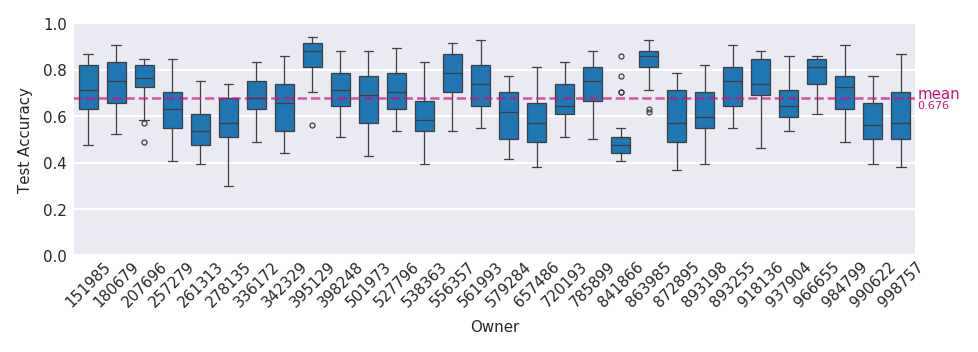

In [36]:
fig = utils_plot_acc_eer_dist(df_plot, "Test Accuracy")
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-acc.pdf")

**Plot Distribution of EER per subject:**

Overall mean: 0.3481


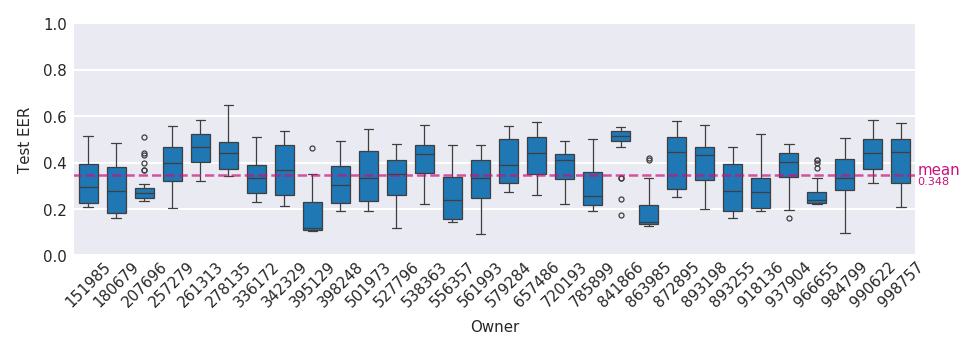

In [37]:
fig = utils_plot_acc_eer_dist(df_plot, "Test EER")
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-eer.pdf")

### 7.3 Evaluate increasing Training Set Size (Training Delay) <a id='7.3'>&nbsp;</a> 

In [38]:
training_set_sizes = [1, 2, 3, 4, 10, 30, 60, 90, 125, 175, 250, 375]  # In samples

deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(5), desc="Run", leave=False):  # Run whole test 5 times
    for n_train_samples in tqdm(training_set_sizes, desc="Train Size", leave=False):
        for df_cv_scenarios, owner, impostors in tqdm(
            utils_generate_cv_scenarios(
                df_ocsvm_train_test,
                samples_per_subject_train=P.samples_per_subject_train,
                samples_per_subject_test=P.samples_per_subject_test,
                limit_train_samples=n_train_samples,  # samples overall
                seed=SEED + i,
                scaler=P.scaler,
                scaler_global=P.scaler_global,
                scaler_scope=P.scaler_scope,
                deep_model=deep_feature_model,
                model_variant=P.model_variant,
                feature_cols=P.feature_cols,
            ),
            desc="Owner",
            total=df_ocsvm_train_test["subject"].nunique(),
            leave=False,
        ):
            X = np.array(df_cv_scenarios["X"].values.tolist())
            y = df_cv_scenarios["label"].values

            train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

            model = OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)

            warnings.filterwarnings("ignore")
            scores = cross_validate(
                model,
                X,
                y,
                cv=train_test_cv,
                scoring={"eer": utils_eer_scorer},
                n_jobs=CORES,
                verbose=0,
                return_train_score=True,
            )
            df_score = pd.DataFrame(scores)
            df_score["owner"] = owner
            df_score["train_samples"] = n_train_samples
            df_score["train_eer"] = df_score[
                "train_eer"
            ].abs()  # Revert scorer's signflip
            df_score["test_eer"] = df_score["test_eer"].abs()
            df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_train_delay_results.csv", index=False)
df_results.head()

KeyboardInterrupt: 

**Load Results from "Training set size" evaluation & prepare for plotting:**

In [ ]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_train_delay_results.csv")
df_plot = (
    df_results[["test_eer", "owner", "train_samples"]]
    .groupby(["owner", "train_samples"], as_index=False)
    .mean()
    .astype({"owner": "category"})
    .rename(
        columns={
            "test_eer": "Test EER",
            "owner": "Owner",
        }
    )
)
df_plot["Training Data in Seconds"] = df_plot["train_samples"] * P.window_size / P.frequency

**Plot EER with increasing number of training samples:**

In [ ]:
utils_plot_training_delay(df_plot)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-train-size.pdf")

### 7.4 Evaluate increasing Test Set Sizes (Detection Delay)<a id='7.4'>&nbsp;</a> 

In [ ]:
# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(50), desc="Run", leave=False):  # Run whole test 5 times
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_test,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            limit_test_samples=1,  # Samples overall
            seed=SEED + i,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_test["subject"].nunique(),
        leave=False,
    ):
        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)

        warnings.filterwarnings("ignore")
        scores = cross_validate(
            model,
            X,
            y,
            cv=train_test_cv,
            scoring={"eer": utils_eer_scorer},
            n_jobs=CORES,
            verbose=0,
            return_train_score=True,
        )
        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner
        df_score["run"] = i
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_detect_delay_results.csv", index=False)
df_results.head()

**Load Results from "Detection Delay" evaluation & prepare for plotting:**

In [ ]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_detect_delay_results.csv")
df_results["owner"] = df_results["owner"].astype(str)
df_plot = df_results.copy()

**Plot Expanding Mean EER and confidence interval:**

In [ ]:
utils_plot_detect_delay(df_plot, factor=P.window_size / P.frequency, xlim=160)
utils_save_plot(
    plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-detection-delay.pdf"
)